# Práctica 2. Aprendizaje Automático

Authors: Carlos Iborra Llopis (100451170), Alejandra Galán Arrospide (100451273) <br>
For additional notes and requirements: https://github.com/carlosiborra/Grupo02-Practica2-AprendizajeAutomatico

**❗If you are willing to run the code yourself, please clone the full GitHub repository, as it contains the necessary folder structures to export images and results❗**

# 0. Table of contents


---
# 1. Requirements


In [1]:
""" Importing necessary libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as st
import scipy
import sklearn

from matplotlib.cbook import boxplot_stats as bps

### 1.1. Cleaning ../data/img/ folder
This way we avoid creating multiple images and sending the old ones to the trash.<br>
Also using this to upload cleaner commits to GitHub.


In [2]:
""" Cleaning the ../data/img/ folder """
import os
import glob

files = glob.glob("../data/img/*")
for f in files:
    if os.path.isfile(f) and f.endswith(".png"):
        os.remove(f)

---
# 2. Reading the datasets
Reading the datasets from the bz2 files, group 2.

In [3]:
import pickle

with open('../data/attrition_available_2.pkl', 'rb') as pkl_file:
    datos = pickle.load(pkl_file)

datos

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,4.0,3.0,NaN,4.0,31.0,Yes,Travel_Frequently,...,0.0,Y,23.0,NaN,1.0,6.0,3.0,5.0,1.0,4
6,6.450877,17.0,NaN,4.0,1.0,3.0,1.0,28.0,Yes,Travel_Rarely,...,2.0,Y,20.0,8.0,1.0,5.0,2.0,0.0,0.0,0
13,8.871421,14.0,2.0,3.0,1.0,2.0,2.0,NaN,Yes,Non-Travel,...,NaN,Y,NaN,8.0,2.0,10.0,NaN,10.0,9.0,9
28,10.713066,6.0,2.0,3.0,4.0,3.0,1.0,44.0,Yes,Travel_Frequently,...,3.0,Y,NaN,NaN,NaN,19.0,2.0,1.0,0.0,0
30,9.662808,11.0,2.0,3.0,1.0,2.0,3.0,26.0,Yes,Travel_Rarely,...,NaN,Y,11.0,8.0,0.0,5.0,5.0,NaN,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,8.316921,6.0,3.0,3.0,4.0,1.0,NaN,42.0,No,Travel_Rarely,...,3.0,NaN,17.0,8.0,1.0,10.0,5.0,3.0,0.0,2
4406,5.897197,8.0,2.0,3.0,4.0,4.0,3.0,29.0,No,NaN,...,2.0,Y,15.0,8.0,0.0,10.0,NaN,3.0,0.0,2
4407,7.149526,18.0,3.0,4.0,1.0,3.0,3.0,25.0,No,Travel_Rarely,...,0.0,Y,20.0,8.0,0.0,5.0,4.0,NaN,1.0,2
4408,9.187612,8.0,2.0,3.0,4.0,1.0,3.0,42.0,No,Travel_Rarely,...,0.0,Y,14.0,8.0,1.0,10.0,NaN,NaN,NaN,8


In [4]:
# Export the data to a csv file to save it
datos.to_csv('../data/attrition_available_2.csv', index=False)

---
# 3. EDA

**Key Concepts of Exploratory Data Analysis**

- **2 types of Data Analysis**
  - Confirmatory Data Analysis
  - Exploratory Data Analysis
- **4 Objectives of EDA**
  - Discover Patterns
  - Spot Anomalies
  - Frame Hypothesis
  - Check Assumptions
- **2 methods for exploration**
  - Univariate Analysis
  - Bivariate Analysis
- **Stuff done during EDA**
  - Trends
  - Distribution
  - Mean
  - Median
  - Outlier
  - Spread measurement (SD)
  - Correlations
  - Hypothesis testing
  - Visual Exploration


## 3.0. Dataset preparation

To conduct exploratory data analysis (EDA) on our real data, we need to prepare the data first. Therefore, we have decided to separate the data into training and test sets at an early stage to avoid data leakage, which could result in an overly optimistic evaluation of the model, among other consequences. This separation will be done by dividing the data prematurely into training and test sets since potential data leakage can occur from the usage of the test partition, especially when including the result variable.

It is important to note that this step is necessary because all the information obtained in this section will be used to make decisions such as dimensionality reduction. Furthermore, this approach makes the evaluation more realistic and rigorous since the test set is not used until the end of the process.

### 3.0.1. Stratified K-Fold
To ensure a fair and unbiased evaluation of our model's performance, we will be using stratified k-fold for dividing our data into training and test sets. Stratified k-fold is a commonly used technique in machine learning that ensures that the distribution of classes in the training and test sets is similar, thus reducing the risk of introducing bias into our model's performance evaluation.

By using stratified k-fold, we can ensure that each fold of the data used for training and testing our model contains a representative sample of all the classes in the dataset. This helps to account for any potential class imbalance in the data, ensuring that our model is trained and tested on a diverse set of data, leading to a more reliable evaluation of its performance.

Note: as we are second group, we will be using 2 as our random state seed.

In [5]:
# Import the necessary libraries
from sklearn.model_selection import StratifiedKFold

In [6]:
""" Train Test Split using Stratified K-Fold """

# Make a copy of the data (we will re-split the data later to ensure that the data is not contaminated)
datos_copy = datos.copy()

# Define the number of folds for stratified k-fold
n_splits = 5

# Initialize the StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over the stratified k-fold splits
for train_index, test_index in stratified_kfold.split(datos_copy, datos_copy['Attrition']):
    # Split the data into training and test sets using the current split indices
    train_set = datos_copy.iloc[train_index]
    test_set = datos_copy.iloc[test_index]
    
    # Extract the features (X) and target (y) from the training and test sets
    X_train = train_set.drop('Attrition', axis=1)  # Drop the 'Attrition' column to get the features
    y_train = train_set['Attrition']  # Extract the 'Attrition' column as the target
    
    X_test = test_set.drop('Attrition', axis=1)  # Drop the 'Attrition' column to get the features
    y_test = test_set['Attrition']  # Extract the 'Attrition' column as the target
 

Check the train-test division correctness

In [7]:
# Show the head of X_train, y_train, X_test, y_test
print("--------------------\n")
print(f"{X_train.head(1)}", f"{y_train.head(1)}", f"{X_test.head(1)}", f"{y_test.head(1)}", sep="\n--------------------\n")
print("--------------------\n")

print(f"{X_train.shape}, {y_train.shape}, {X_test.shape}, {y_test.shape}")

# Check is division summatory is correct
if X_train.shape[0] + X_test.shape[0] == datos_copy.shape[0]:
    print(
        f"\nThe train test division is correct: {X_train.shape[0]} + {X_test.shape[0]} = {datos_copy.shape[0]}"
    )
else:
    print("\nERROR: The train test division is incorrect")


--------------------

        hrs  absences  JobInvolvement  PerformanceRating  \
1  7.315971      13.0             2.0                4.0   

   EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance   Age  \
1                      3.0              NaN              4.0  31.0   

      BusinessTravel              Department  ...  NumCompaniesWorked  Over18  \
1  Travel_Frequently  Research & Development  ...                 0.0       Y   

  PercentSalaryHike  StandardHours  StockOptionLevel TotalWorkingYears  \
1              23.0            NaN               1.0               6.0   

   TrainingTimesLastYear YearsAtCompany YearsSinceLastPromotion  \
1                    3.0            5.0                     1.0   

   YearsWithCurrManager  
1                     4  

[1 rows x 30 columns]
--------------------
1    Yes
Name: Attrition, dtype: object
--------------------
          hrs  absences  JobInvolvement  PerformanceRating  \
108  7.100332       NaN             4.0           

In [8]:
# Check the train-test division correctness by comparing the class distribution in the original dataset and the train and test sets.
print("\n--------------------\n")
print("Original dataset class distribution(porcentual):\n", datos_copy['Attrition'].value_counts(normalize=True))
print("Original dataset class distribution (numerical):\n", datos_copy['Attrition'].value_counts())
print("\n--------------------\n")
print("Train set class distribution(porcentual):\n", y_train.value_counts(normalize=True))
print("Train set class distribution (numerical):\n", y_train.value_counts())
print("\n--------------------\n")
print("Test set class distribution (porcentual):\n", y_test.value_counts(normalize=True))
print("Test set class distribution (numerical):\n", y_test.value_counts())
print("\n--------------------\n")


--------------------

Original dataset class distribution(porcentual):
 No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64
Original dataset class distribution (numerical):
 No     3699
Yes     711
Name: Attrition, dtype: int64

--------------------

Train set class distribution(porcentual):
 No     0.838719
Yes    0.161281
Name: Attrition, dtype: float64
Train set class distribution (numerical):
 No     2959
Yes     569
Name: Attrition, dtype: int64

--------------------

Test set class distribution (porcentual):
 No     0.839002
Yes    0.160998
Name: Attrition, dtype: float64
Test set class distribution (numerical):
 No     740
Yes    142
Name: Attrition, dtype: int64

--------------------



As we can observe, the class distribution is almost perfectly preserved in both the training and test sets and the sum of the number of rows in the train and test give us the total amount of rows in the raw dataset. This is due to the fact that the stratified k-fold algorithm does not guarantee that the class distribution is exactly the same in each fold, but rather that it is similar.<br>
Also, we can notice how the distribution of the classes is very similar in both the training and test sets, which is a good sign.

## 3.1. Dataset and problem description

The dataset we are given contains the following atributes information:

0. **hrs**: The number of hours worked by the employee (float64)
1. **absences**: The number of absences taken by the employee (float64)
2. **JobInvolvement**: The level of involvement the employee has in their job (float64)
3. **PerformanceRating**: The employee's performance rating (float64)
4. **EnvironmentSatisfaction**: The level of satisfaction the employee has with their work environment (float64)
5. **JobSatisfaction**: The level of satisfaction the employee has with their job (float64)
6. **WorkLifeBalance**: The balance between work and personal life for the employee (float64)
7. **Age**: The age of the employee (float64)
8. **Attrition**: Whether the employee has left the company or not (object) -> **Target variable**
9. **BusinessTravel**: The frequency of the employee's business travel (object)
10. **Department**: The department the employee works in (object)
11. **DistanceFromHome**: The distance from the employee's home to their workplace (float64)
12. **Education**: The highest level of education attained by the employee (int64)
13. **EducationField**: The field of study the employee specialized in (object)
14. **EmployeeCount**: The number of employees in the company (float64)
15. **EmployeeID**: A unique identifier for each employee (int64)
16. **Gender**: The gender of the employee (object)
17. **JobLevel**: The employee's job level in the company hierarchy (float64)
18. **JobRole**: The specific role the employee has in their department (object)
19. **MaritalStatus**: The employee's marital status (object)
20. **MonthlyIncome**: The employee's monthly income (float64)
21. **NumCompaniesWorked**: The number of companies the employee has worked for before joining the current company (float64)
22. **Over18**: Whether the employee is over 18 years old (presumably all employees are) (object)
23. **PercentSalaryHike**: The percentage of salary increase the employee received in their last salary hike (float64)
24. **StandardHours**: The standard number of working hours in the company (float64)
25. **StockOptionLevel**: The level of stock option the employee has (float64)
26. **TotalWorkingYears**: The total number of years the employee has worked (float64)
28. **TrainingTimesLastYear**: The number of times the employee received training in the last year (float64)
29. **YearsAtCompany**: The number of years the employee has been with the company (float64)
30. **YearsSinceLastPromotion**: The number of years since the employee's last promotion (float64)
31. **YearsWithCurrManager**: The number of years the employee has been with their current manager (float64)

**Note**: the values in between parenthesis correspond to the value type of each column in the dataset.

In [9]:
num_atributos  = len(datos.keys())
print("We have", num_atributos, "attributes.")
num_instances = len(datos)
print("We have", num_instances, "instances.")

We have 31 attributes.
We have 4410 instances.


In [10]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3528 entries, 1 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2917 non-null   float64
 1   absences                 2860 non-null   float64
 2   JobInvolvement           2888 non-null   float64
 3   PerformanceRating        2834 non-null   float64
 4   EnvironmentSatisfaction  2757 non-null   float64
 5   JobSatisfaction          2914 non-null   float64
 6   WorkLifeBalance          2891 non-null   float64
 7   Age                      2892 non-null   float64
 8   Attrition                3528 non-null   object 
 9   BusinessTravel           2929 non-null   object 
 10  Department               2861 non-null   object 
 11  DistanceFromHome         2975 non-null   float64
 12  Education                2904 non-null   float64
 13  EducationField           3528 non-null   object 
 14  EmployeeCount           

### 3.1.1. Dataset visualization

/tmp/ipykernel_7629/1077201715.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_set.hist(ax=ax)


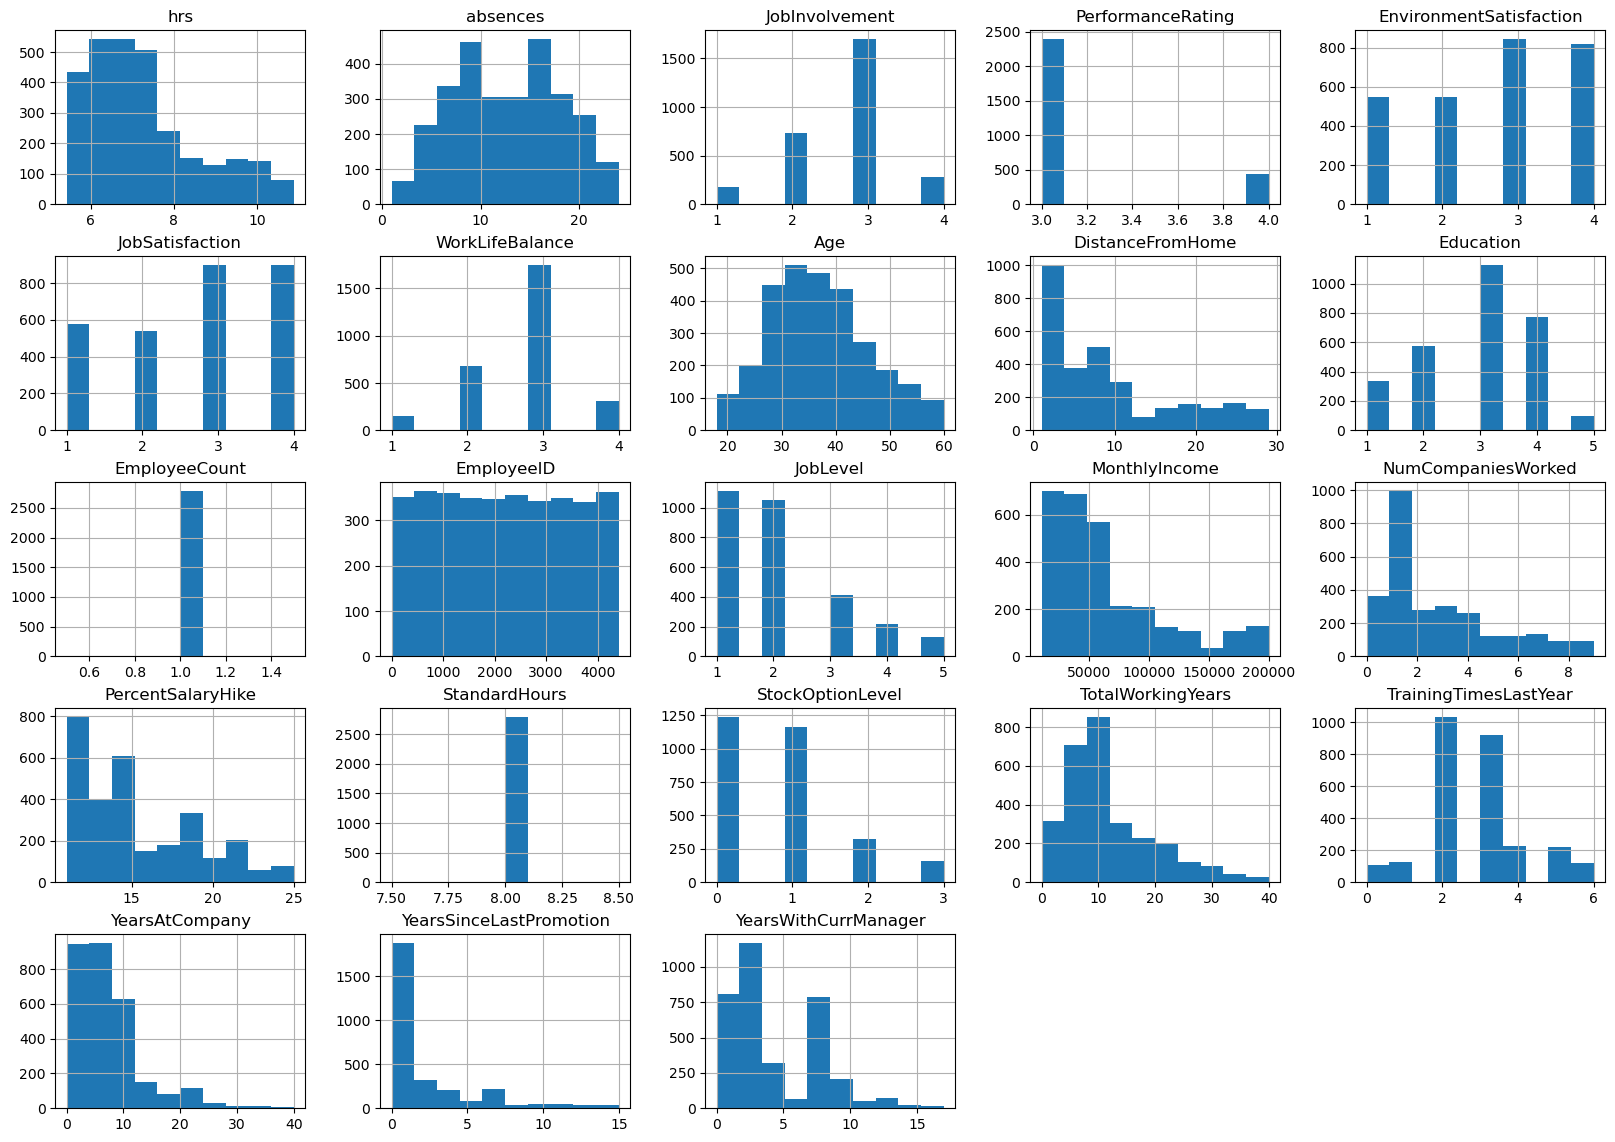

In [11]:
""" Histogram for visualization of the numerical variables """
fig, ax = plt.subplots(figsize=(20, 14))
train_set.hist(ax=ax)
plt.show()

Thanks to this visualization we can note several things. 

1. **Employee ID** appears to have the same amount of each number in its range. This is very logical taking into account that this attribute is an identifier. This attribute will be eliminated in the future. 

2. **Standard Hours** seems to have a unique value of 8. This attribute will need further analysis in order to consider its deletion. 

3. As Standard Hours, **Employee Count** seems to have a unique value of 1. This attribute will also need further analysis. 

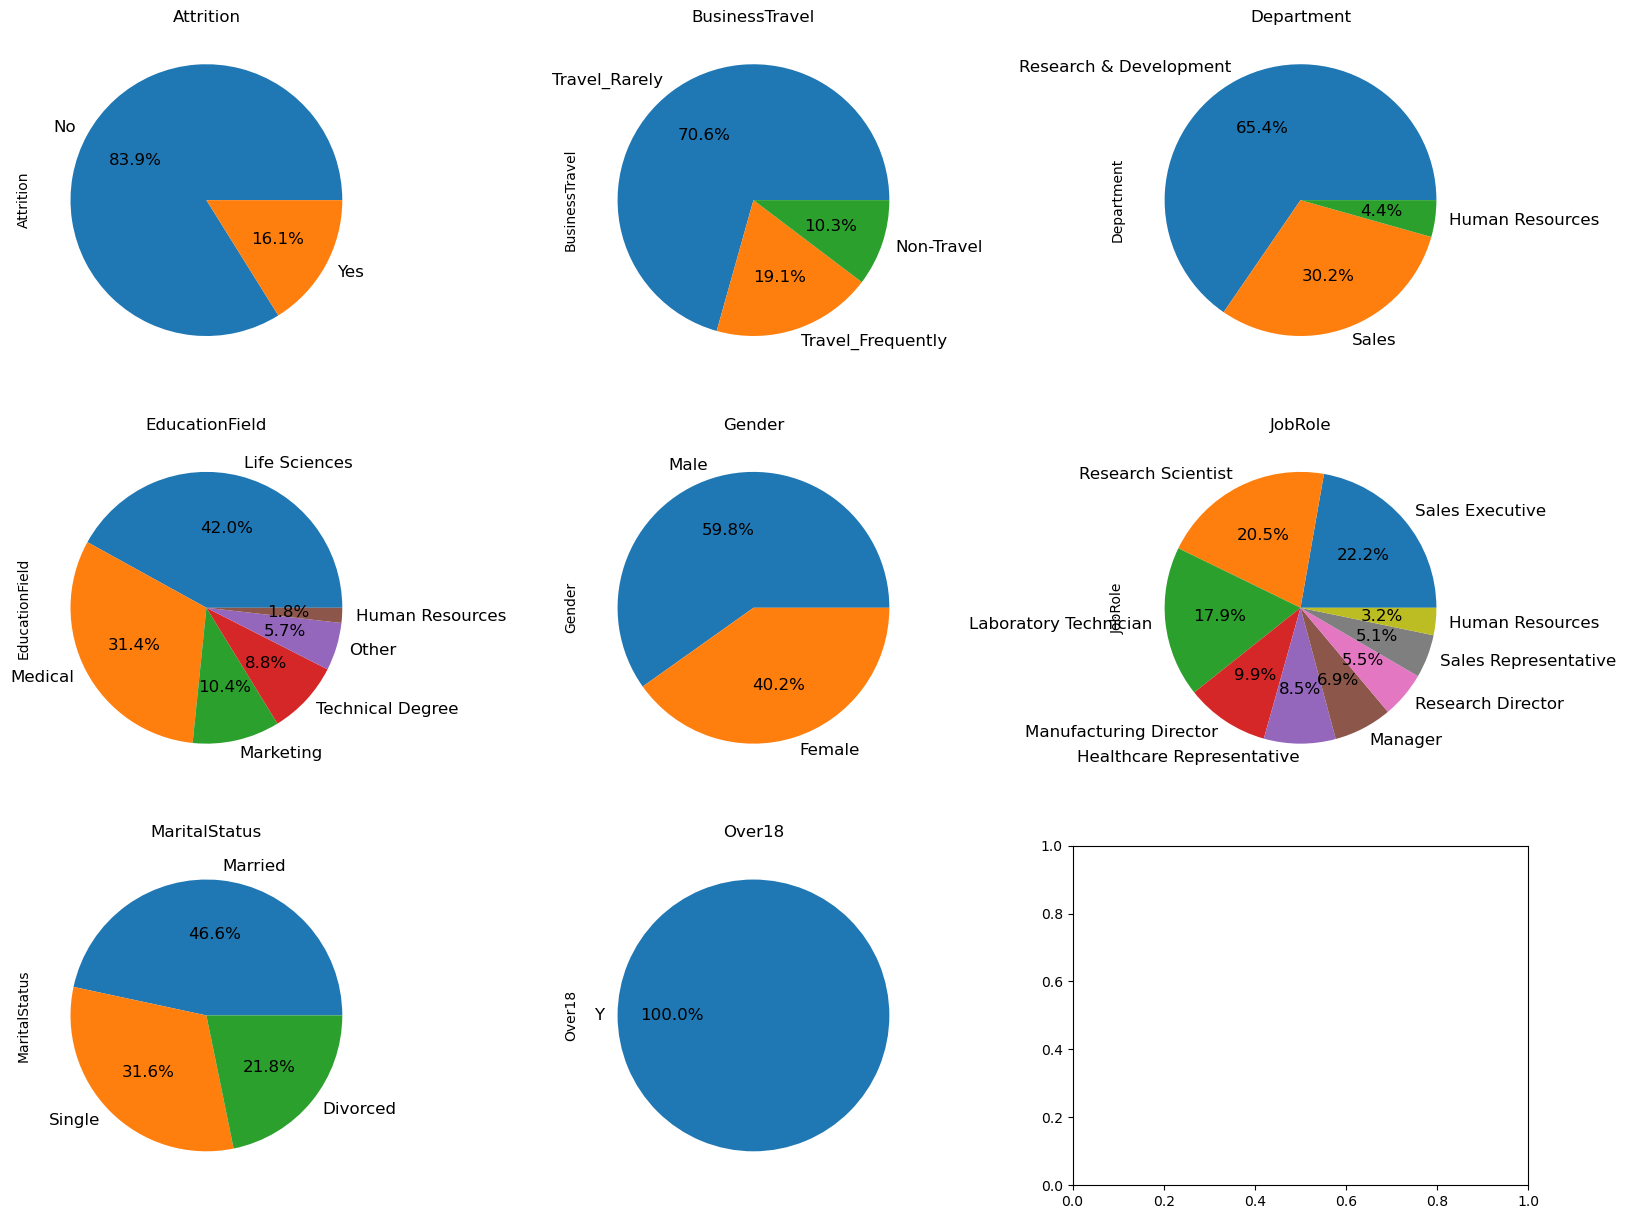

In [12]:
""" Pie series to plot and visualize for categorical variables """
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for i, col in enumerate(train_set.select_dtypes(include='object')):
    train_set[col].value_counts().plot.pie(ax=ax[i//3, i%3], autopct='%1.1f%%', fontsize=12, title=col)
plt.show()

From this numerical visualization, we can also obtain relevant information.<br>
1. The attribte **BusinessTravel** is an ordinal attribute. This means that the natural order of the values is important. In this case, the order is: **Non-Travel**, **Travel_Rarely**, **Travel_Frequently**. This attribute will be transformed in the future.
   
2. The attribute **'Over18'** has a constant value, which means it adds no value to the analysis. Therefore, it will be dropped in the further sections

## 3.2. Attribute type division

As we have seen, there are two types of attributes in the dataset: numerical and categorical. In this section, we will divide the attributes into these two types and analyze them separately.

But that's not all. Categorical attributes are further divided into two types: ordinal (attributes that have a natural order) and nominal (attributes that do not have a natural order). Therefore, we will divide the categorical attributes into these two types and analyze them separately.

**Note**: this is important as it prevents errors when treating and measuring data in the EDA. For example, we cannot calculate the mean of a categorical attribute, but we can calculate the mean of a numerical attribute.

### 3.2.1. Categorical and numerical attributes

In [13]:
# First of all, we divide our data-set into two general groups, categorical and numerical variables
X_train_str = X_train.select_dtypes(include=object)
X_train_num = X_train.select_dtypes(exclude=object)
print(X_train_str.head(2))
print(X_train_num.head(2))

      BusinessTravel              Department EducationField  Gender  \
1  Travel_Frequently  Research & Development  Life Sciences  Female   
6      Travel_Rarely  Research & Development        Medical     NaN   

              JobRole MaritalStatus Over18  
1  Research Scientist        Single      Y  
6     Sales Executive           NaN      Y  
        hrs  absences  JobInvolvement  PerformanceRating  \
1  7.315971      13.0             2.0                4.0   
6  6.450877      17.0             NaN                4.0   

   EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance   Age  \
1                      3.0              NaN              4.0  31.0   
6                      1.0              3.0              1.0  28.0   

   DistanceFromHome  Education  ...  MonthlyIncome  NumCompaniesWorked  \
1              10.0        1.0  ...        41890.0                 0.0   
6              11.0        2.0  ...        58130.0                 2.0   

   PercentSalaryHike  StandardHours 

### 3.2.2. Ordinal and nominal attributes

After dividing the dataset into categorical and numerical, we will divide the categorical ones into other two new subsets, ordinal and nominal. This will later allow us to apply different preprocessing techniques to each subset.

In [14]:
# Next, we create a new subset of the ordinal variables
X_train_ordinals = X_train[['BusinessTravel']]
print(X_train_ordinals.head())

       BusinessTravel
1   Travel_Frequently
6       Travel_Rarely
13         Non-Travel
28  Travel_Frequently
30      Travel_Rarely


In [15]:
# Next, we take out the ordinal variables from the categorical variables group -> nominal group
X_train_nominal = X_train_str.drop('BusinessTravel', axis=1)
print(X_train_nominal.head())

                Department EducationField  Gender             JobRole  \
1   Research & Development  Life Sciences  Female  Research Scientist   
6   Research & Development        Medical     NaN     Sales Executive   
13  Research & Development        Medical    Male  Research Scientist   
28  Research & Development        Medical    Male  Research Scientist   
30  Research & Development        Medical    Male  Research Scientist   

   MaritalStatus Over18  
1         Single      Y  
6            NaN      Y  
13       Married      Y  
28      Divorced      Y  
30      Divorced      Y  


We print the column names of each subset to check that the division was done correctly.

In [16]:
# Print the columns of the two new data-sets
print("Numerical variables:", list(X_train_num.columns))
print("Categorical variables:", list(X_train_str.columns))
print("  - Ordinal variables:", list(X_train_ordinals.columns))
print("  - Nominal variables:", list(X_train_nominal.columns))

Numerical variables: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical variables: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']
  - Ordinal variables: ['BusinessTravel']
  - Nominal variables: ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']


## 3.3. Irrelevant and constant attributes

After dividing the dataset into three different subsets, we will drop the attributes that are irrelevant or constant in each subset. This will allow us to reduce the dimensionality of the dataset and make it easier to analyze.

### 3.3.1. Elimination of irrelevant attributes

In [17]:
X_train_num.columns

Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [18]:
# We take out the EmproyeeID column from the numerical variables group since its an identifier 
X_train_num = X_train_num.drop('EmployeeID', axis=1)
X_train_num.columns

Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [19]:
# We look for variables with only one value, in order to take them out
for i in X_train_nominal.columns:
  print(X_train_str[i].unique())

['Research & Development' nan 'Human Resources' 'Sales']
['Life Sciences' 'Medical' 'Human Resources' 'Marketing'
 'Technical Degree' 'Other']
['Female' nan 'Male']
['Research Scientist' 'Sales Executive' 'Manager' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative'
 'Sales Representative' nan 'Research Director' 'Human Resources']
['Single' nan 'Married' 'Divorced']
['Y' nan]


In [20]:
print(X_train_num.columns)

Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


### 3.3.2. Elimination of constant attributes

#### 3.3.2.1. Constant numerical attributes

We check if the assumptions about the constantness made in previous sections about the attributes 'StandardHours' and 'EmployeeCount' are correct.

In [21]:
# Print "StandardHours" distribution of values
print(list(X_train_num['StandardHours'].unique()))
print(X_train_num['StandardHours'].value_counts())

[nan, 8.0]
8.0    2797
Name: StandardHours, dtype: int64


In [22]:
# Print "EmployeeCount" distribution of values
print(list(X_train_num['EmployeeCount'].unique()))
print(X_train_num['EmployeeCount'].value_counts())

[1.0, nan]
1.0    2790
Name: EmployeeCount, dtype: int64


As we can see, both the attributes we suspected have a constant value and are not useful for the analysis. We are going to conduct a quick overall analysis to ensure that we are not overlooking any other constant attributes.

In [23]:
for i in X_train_num.columns: 
  unique_vals = list(X_train_num[i].unique())
  print(f"{i} has {len(unique_vals)} unique values")

hrs has 2917 unique values
absences has 25 unique values
JobInvolvement has 5 unique values
PerformanceRating has 3 unique values
EnvironmentSatisfaction has 5 unique values
JobSatisfaction has 5 unique values
WorkLifeBalance has 5 unique values
Age has 44 unique values
DistanceFromHome has 30 unique values
Education has 6 unique values
EmployeeCount has 2 unique values
JobLevel has 6 unique values
MonthlyIncome has 1290 unique values
NumCompaniesWorked has 11 unique values
PercentSalaryHike has 16 unique values
StandardHours has 2 unique values
StockOptionLevel has 5 unique values
TotalWorkingYears has 41 unique values
TrainingTimesLastYear has 8 unique values
YearsAtCompany has 37 unique values
YearsSinceLastPromotion has 17 unique values
YearsWithCurrManager has 18 unique values


We drop constant attributes in the numerical subset: 'StandardHours' and 'EmployeeCount'.

In [24]:
X_train_num = X_train_num.drop('StandardHours', axis=1 )
X_train_num.columns

Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'JobLevel',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [25]:
X_train_num = X_train_num.drop('EmployeeCount', axis=1 )
X_train_num.columns

Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

#### 3.3.2.2. Constant categorical attributes

In [26]:
# Print "Over18" distribution of values
print(list(X_train_nominal['Over18'].unique()))
print(X_train_nominal['Over18'].value_counts())

['Y', nan]
Y    2841
Name: Over18, dtype: int64


As expected, Over18 only has only one value different from Nan, therefore, it does not provide any valuable information, so we drop it from the dataset.

In [27]:
X_train_nominal = X_train_nominal.drop ('Over18', axis=1 )
X_train_nominal.columns

Index(['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus'], dtype='object')

In [28]:
# We check all the subsets we will be using 
print(X_train_nominal.columns)
print(X_train_num.columns)
print(X_train_ordinals.columns)
print(len(X_train_num.columns)+len(X_train_nominal.columns) + len(X_train_ordinals.columns))

Index(['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus'], dtype='object')
Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')
Index(['BusinessTravel'], dtype='object')
26


As can be noticed, we obtained 26 attributes, so we have reduced the dimensionality by 4 attributes (13.33%) with respect to the original dataset.

## 3.4. Missing values

We check the number the total number of missing values in the dataset in order to know if we have to clean the dataset or not.<br>Here we will be using the `train_set` partition (and not X_train nor y_train) as it contains both the target variable and the rest of the features.

In [29]:
print(train_set.isna().sum())

hrs                        611
absences                   668
JobInvolvement             640
PerformanceRating          694
EnvironmentSatisfaction    771
JobSatisfaction            614
WorkLifeBalance            637
Age                        636
Attrition                    0
BusinessTravel             599
Department                 667
DistanceFromHome           553
Education                  624
EducationField               0
EmployeeCount              738
EmployeeID                   0
Gender                     712
JobLevel                   602
JobRole                    632
MaritalStatus              618
MonthlyIncome              650
NumCompaniesWorked         771
Over18                     687
PercentSalaryHike          612
StandardHours              731
StockOptionLevel           640
TotalWorkingYears          658
TrainingTimesLastYear      770
YearsAtCompany             588
YearsSinceLastPromotion    619
YearsWithCurrManager         0
dtype: int64


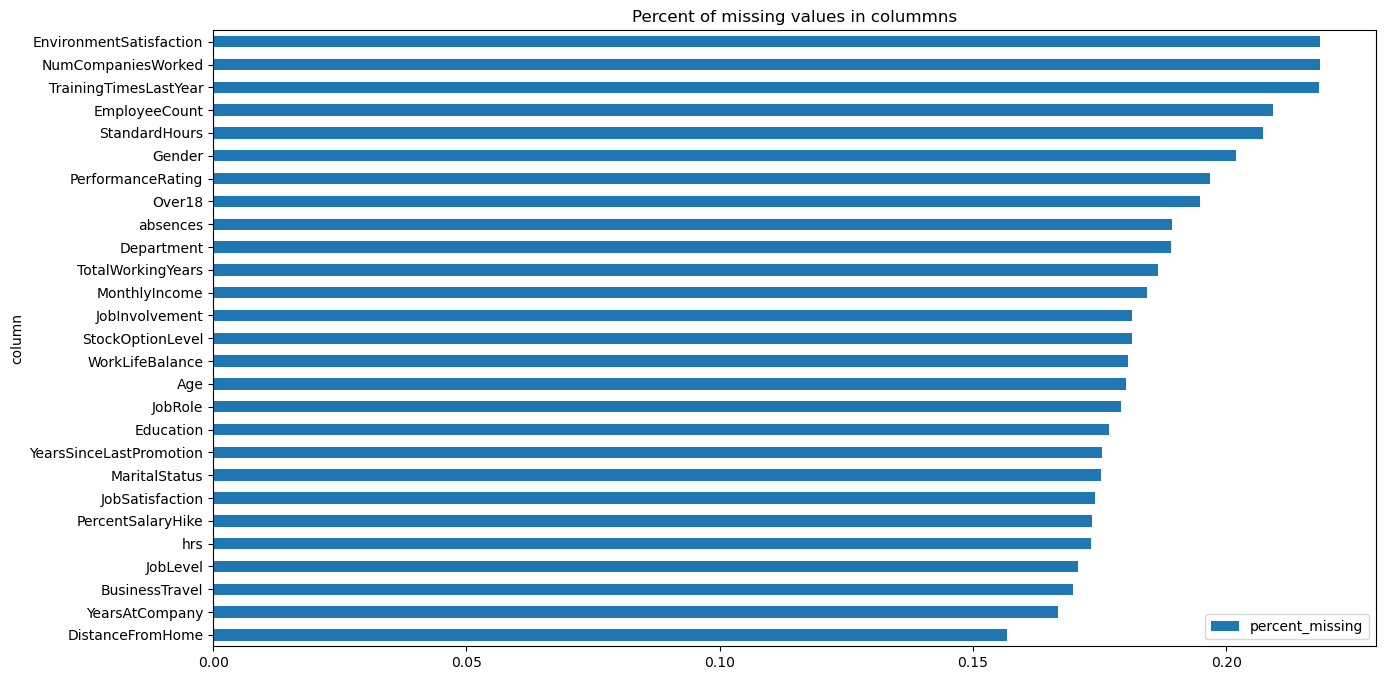

In [30]:
""" Plot in a barplot the percentage of missing values in each column """
import pylab

data = [(col, train_set[col].isnull().sum() / len(train_set))
        for col in train_set.columns if train_set[col].isnull().sum() > 0]
col_names = ['column', 'percent_missing']
missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
pylab.rcParams['figure.figsize'] = (15, 8)
missing_df.plot(kind='barh', x='column', y='percent_missing');
plt.title('Percent of missing values in colummns');

### 3.2.1. Missing values visualization

<Axes: >

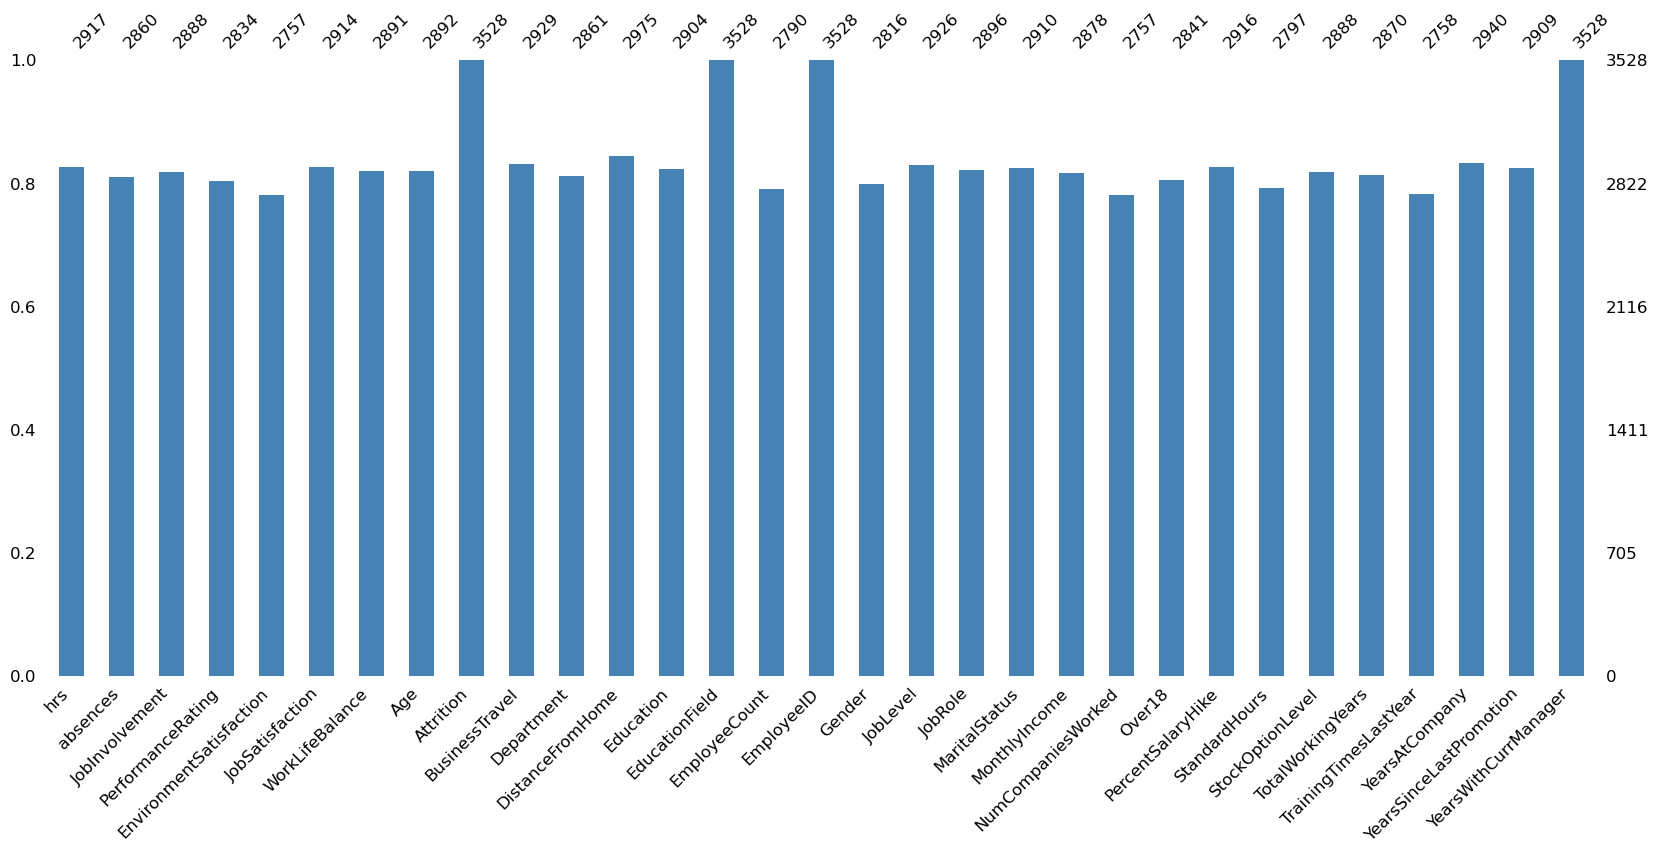

In [31]:
""" Missing values bar plot """
msno.bar(train_set, figsize=(20, 8), fontsize=12, color='steelblue', labels=True)

<Axes: >

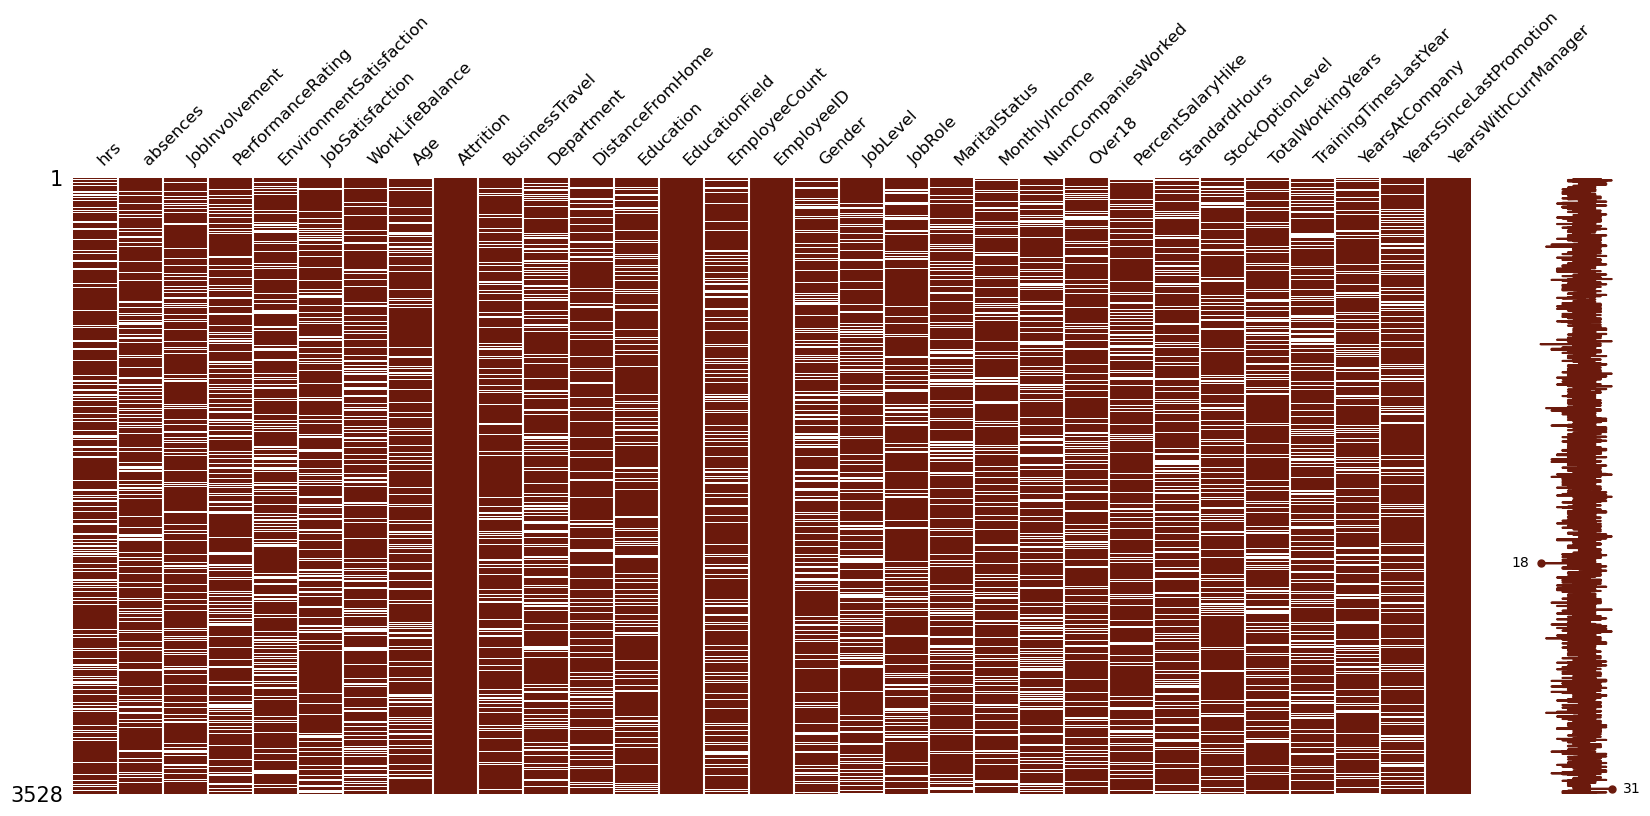

In [32]:
""" Missing values matrix """
msno.matrix(train_set, figsize=(20, 8), fontsize=12, color=(0.42, 0.1, 0.05))

<Axes: >

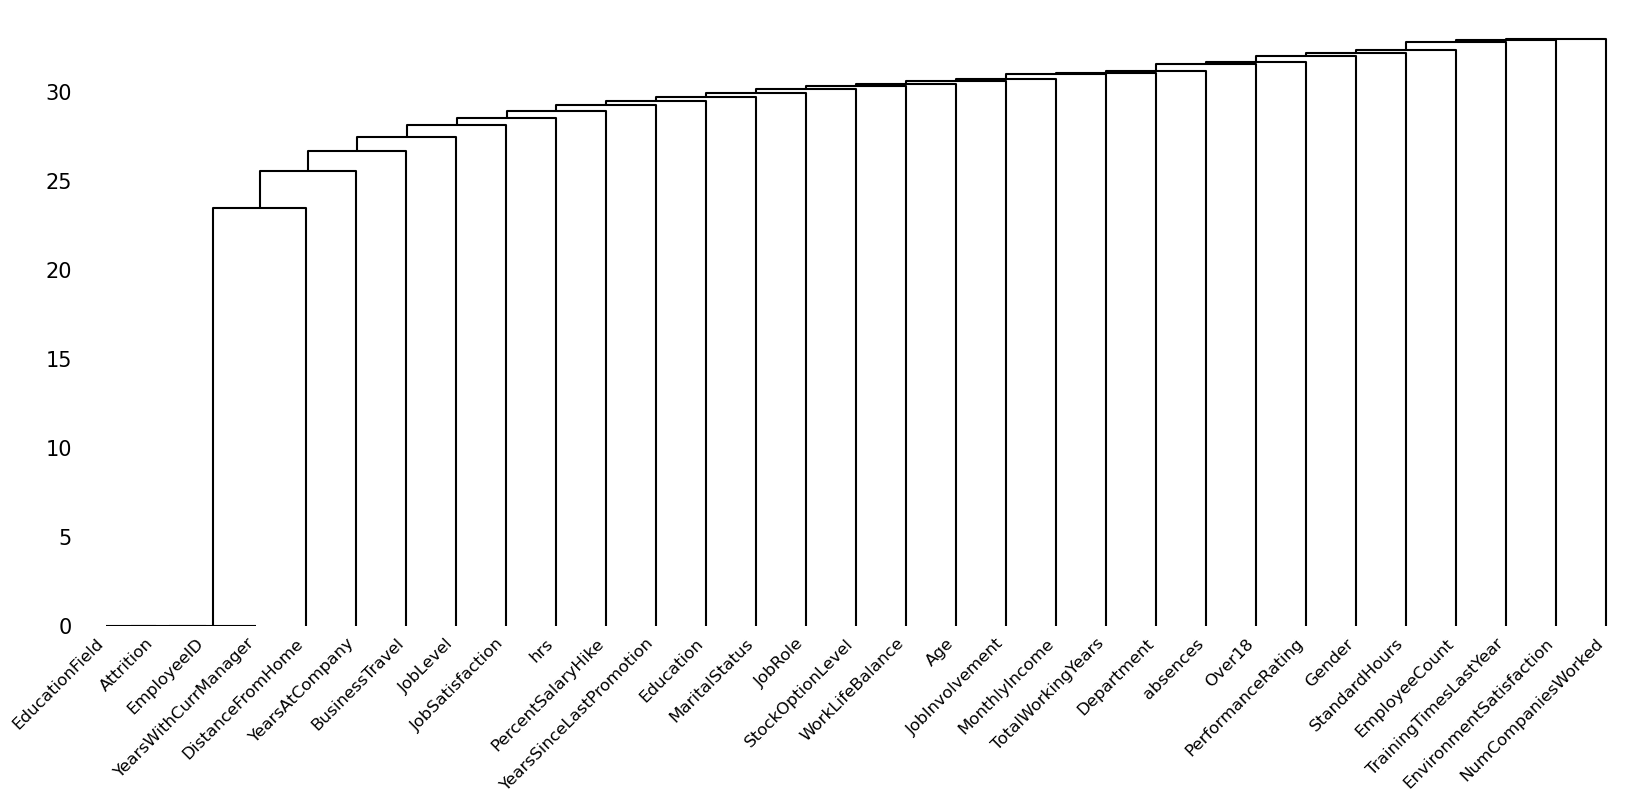

In [33]:
""" Missing values dendrogram """
msno.dendrogram(train_set, figsize=(20, 8), fontsize=12, orientation='top')

### 3.2.2. Observations and conclusion

- Many variables have a significant number of missing values, ranging from 588 to over 771 missing values, which means that having 4410 rows in the dataset, we have a significant number of missing values ranging from 13.3% to 17.5% of the total number of rows in the dataset, which is significant.
  
  These variables include: 'hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EmployeeCount', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', and 'YearsSinceLastPromotion'.

- Some variables have no missing values, such as 'Attrition' (as it is the target variable), 'EducationField', and 'YearsWithCurrManager'.

It is important to note that missing values can have an impact on the quality and reliability of the data and may require appropriate handling techniques, such as imputation or deletion, depending on the specific analysis or modeling objectives.

Note that none of the attributes have a missing rate high enough for them to be eliminated because of it. It is possible to use imputation to solve this problem. 

## 3.5. Outliers


Detecting outliers in a dataset before training a model is crucial because outliers can significantly affect the performance and accuracy of the model. Outliers are data points that deviate significantly from the rest of the dataset and can cause the model to learn incorrect patterns and relationships. When outliers are present in the data, they can also increase the variance of the model, which can result in overfitting. Overfitting occurs when the model fits too closely to the training data, leading to poor generalization to new data. Therefore, it is important to detect and handle outliers properly to ensure the model's accuracy and robustness.

**Note:** outliers are only useful when the attributes are not categorical, as they are not useful for classification problems. Therefore, only the numerical attributes (`X_train_num`) will be considered in this section.

### 3.5.1. Outliers visualization

#### 3.5.1.1. Boxplot

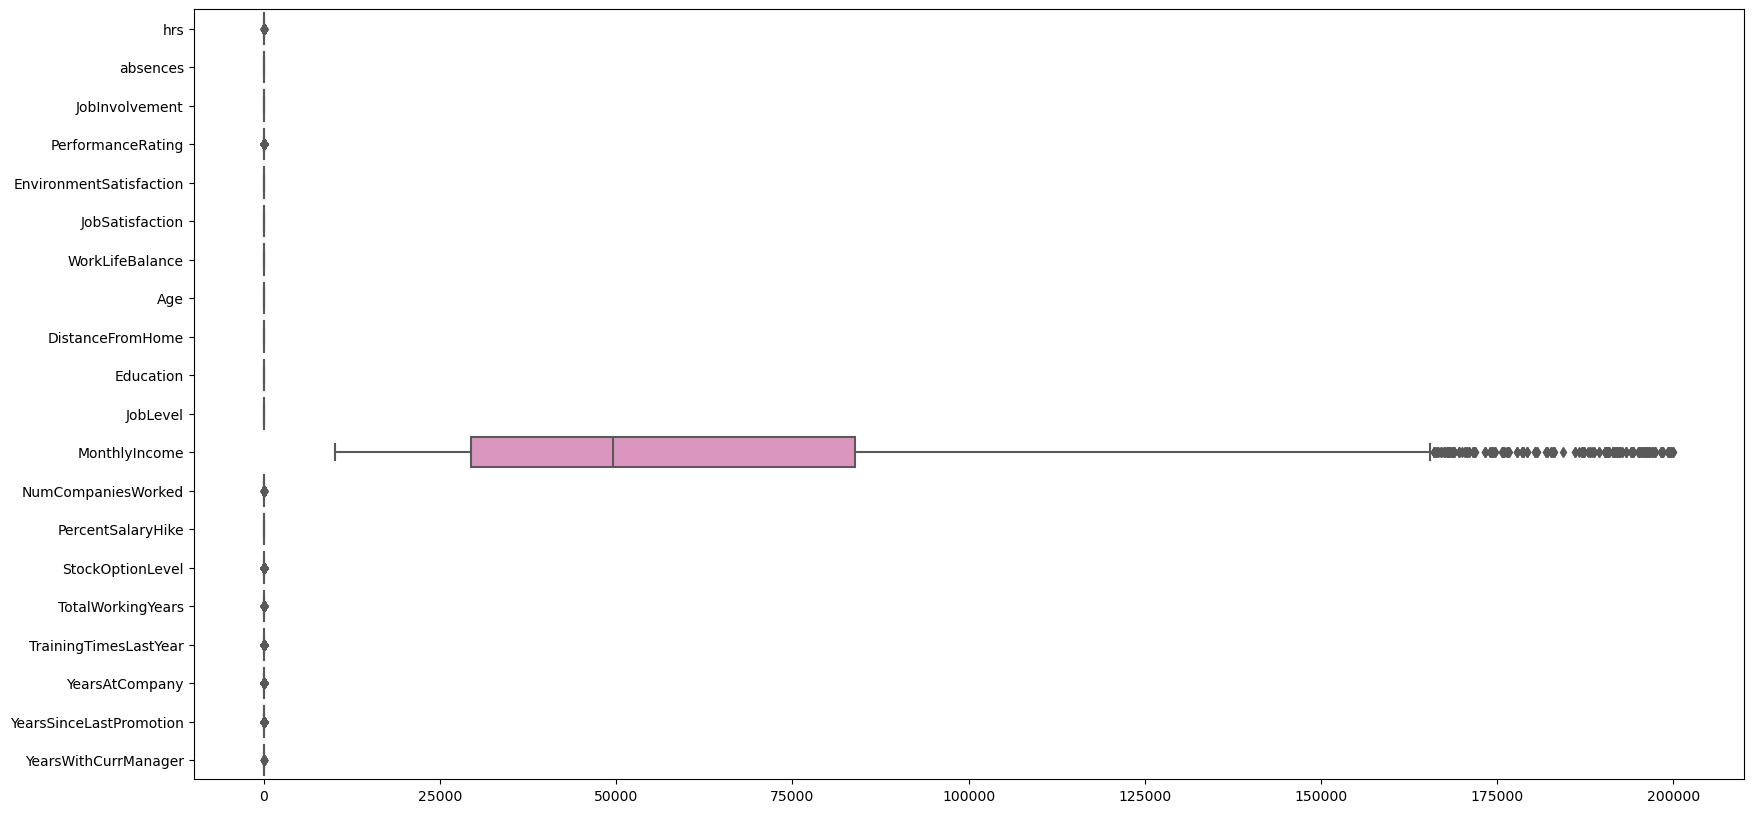

In [34]:
""" Box plot to detect outliers """
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=X_train_num, orient='h', palette='Set2') # ,showfliers=False
plt.show()

#### 3.5.1.2. Histogram

/tmp/ipykernel_7629/923882639.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X_train_num.hist(ax=ax)


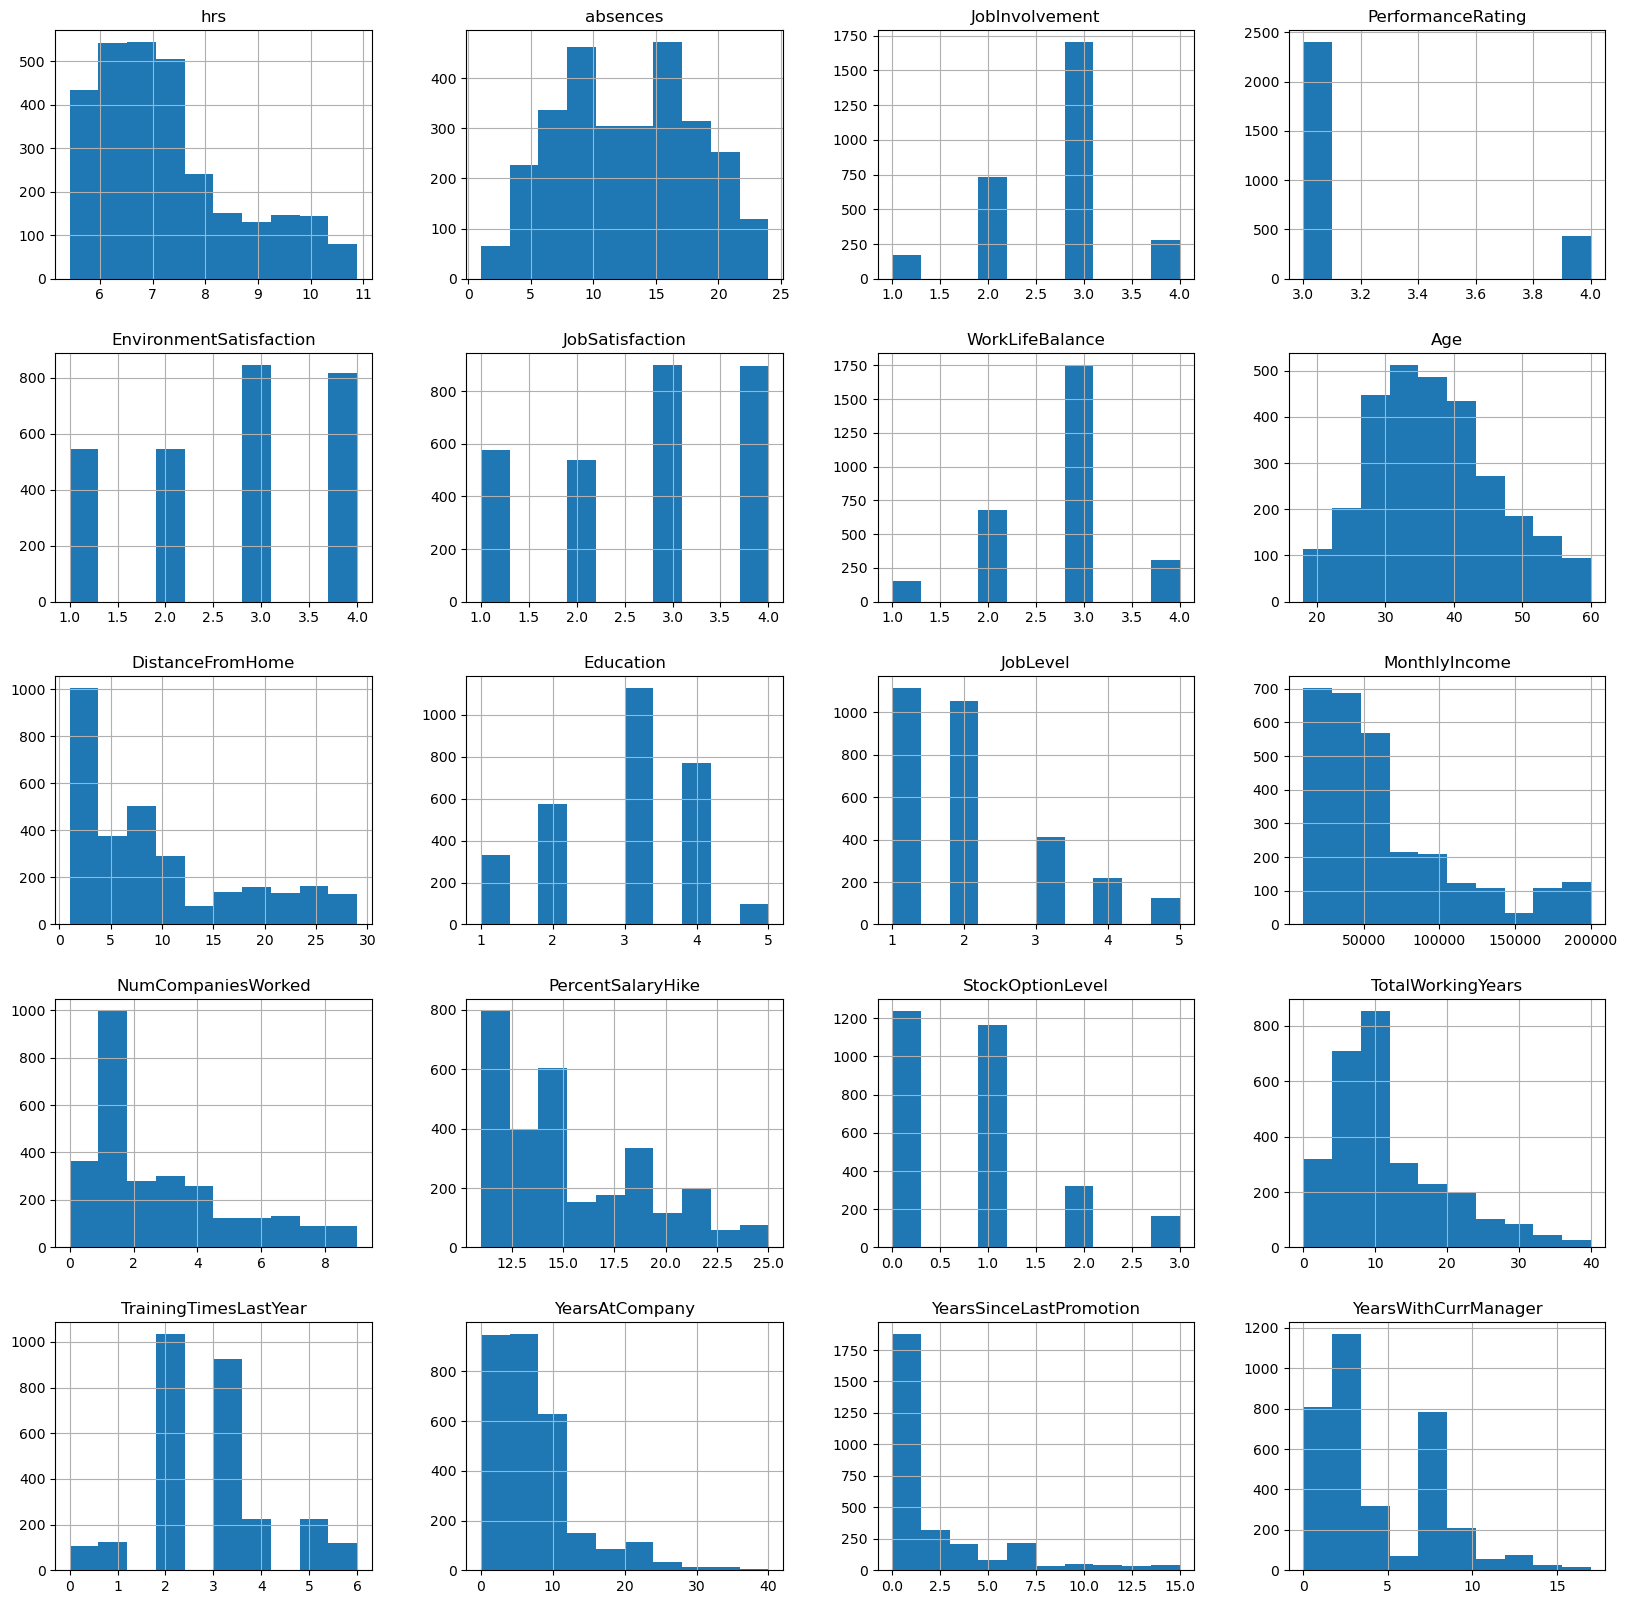

In [35]:
""" Histograms to detect outliers """
fig, ax = plt.subplots(figsize=(20, 20))
X_train_num.hist(ax=ax)
plt.show()

#### 3.5.1.3. Skewness and kurtosis
Skewness and kurtosis are commonly used to measure the shape of a distribution. Skewness measures the degree of asymmetry in the distribution, while kurtosis measures the degree of flatness in the distribution compared to a normal distribution.<br>
We will look for observations that are far from the central tendency of the distribution and may indicate the presence of extreme values or data points that do not fit the pattern of the majority of the data (which as expected, happens to be the case in this dataset).

**Skewness**: measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.

In [36]:
""" Skewness """
X_train_num.skew().sort_values(ascending=False)

YearsSinceLastPromotion    2.010269
PerformanceRating          1.934941
YearsAtCompany             1.711169
MonthlyIncome              1.352524
TotalWorkingYears          1.139681
NumCompaniesWorked         1.058816
JobLevel                   1.043887
StockOptionLevel           0.951557
DistanceFromHome           0.939869
hrs                        0.880414
YearsWithCurrManager       0.805330
PercentSalaryHike          0.801963
TrainingTimesLastYear      0.547272
Age                        0.394624
absences                   0.006601
Education                 -0.263638
EnvironmentSatisfaction   -0.297571
JobSatisfaction           -0.336527
JobInvolvement            -0.512700
WorkLifeBalance           -0.539936
dtype: float64

/tmp/ipykernel_7629/963369132.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train_num.skew(), color="blue", axlabel="Skewness")


<Axes: xlabel='Skewness', ylabel='Density'>

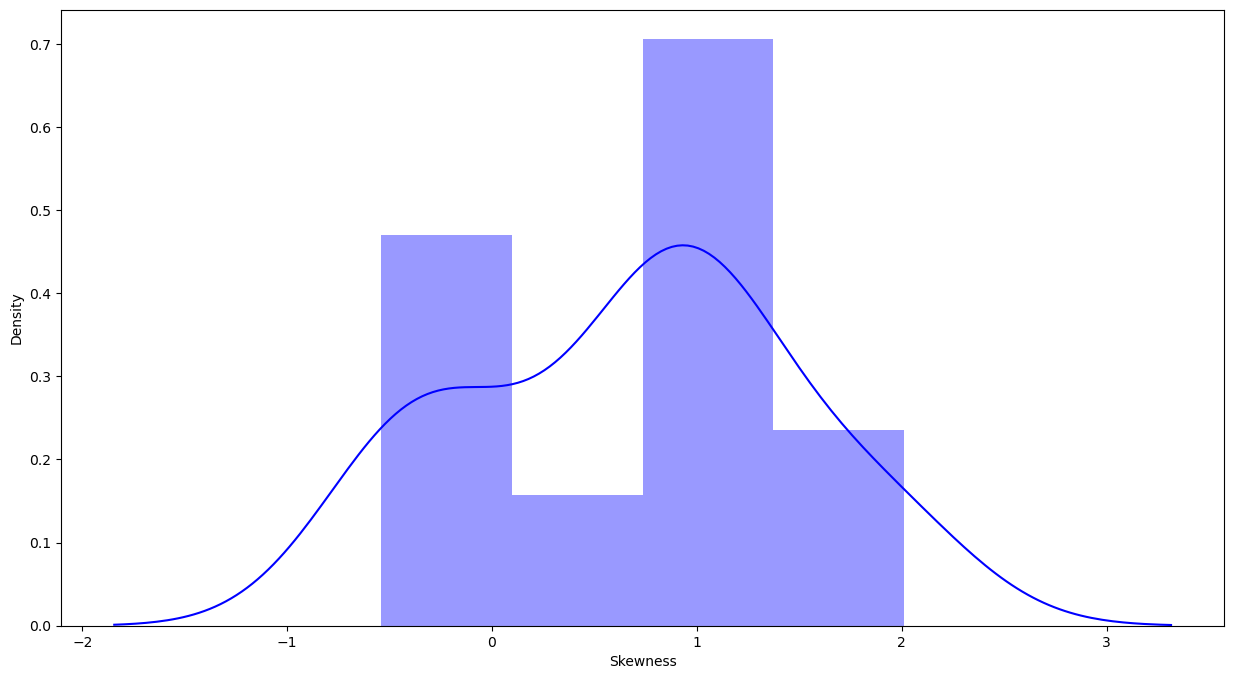

In [37]:
sns.distplot(X_train_num.skew(), color="blue", axlabel="Skewness")

**Kurtosis**: measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.

In [38]:
""" Kurtosis """
X_train_num.kurt().sort_values(ascending=False)

YearsSinceLastPromotion    3.751488
YearsAtCompany             3.688171
PerformanceRating          1.745229
MonthlyIncome              0.960551
TotalWorkingYears          0.959773
TrainingTimesLastYear      0.525953
JobLevel                   0.428930
WorkLifeBalance            0.410453
StockOptionLevel           0.317629
JobInvolvement             0.260644
NumCompaniesWorked         0.112778
YearsWithCurrManager       0.082264
hrs                       -0.119057
DistanceFromHome          -0.280372
PercentSalaryHike         -0.315038
Age                       -0.426820
Education                 -0.561514
absences                  -1.087776
JobSatisfaction           -1.210908
EnvironmentSatisfaction   -1.222330
dtype: float64

/tmp/ipykernel_7629/1532000095.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train_num.kurt(), color="r", axlabel="Kurtosis", norm_hist=False, kde=True, rug=False)


<Axes: xlabel='Kurtosis', ylabel='Density'>

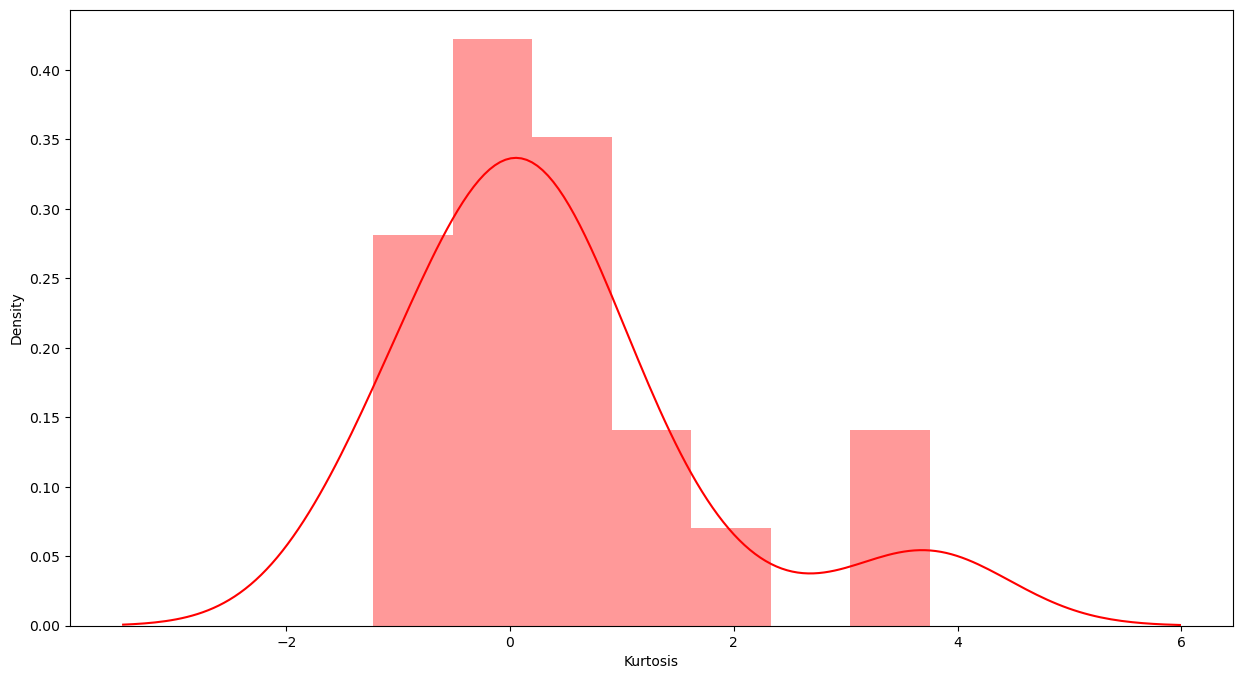

In [39]:
sns.distplot(X_train_num.kurt(), color="r", axlabel="Kurtosis", norm_hist=False, kde=True, rug=False)

### 3.5.2. Importance of outliers on our models

- **Logistic regression** aims to fit a linear boundary that separates the two classes in the dataset. When outliers are present, they can shift this boundary and lead to incorrect predictions. Additionally, outliers can affect the estimation of the regression coefficients and standard errors, leading to biased parameter estimates and incorrect hypothesis tests.

- **Boosting** algorithms are sensitive to outliers in the training data, as they aim to fit the data as closely as possible. Outliers can have a significant impact on the model's performance and can lead to overfitting.<br>
In boosting, each subsequent model in the sequence aims to correct the errors made by the previous model, focusing on the misclassified samples. Outliers are usually given high weights in the subsequent models to improve their performance on these samples. This can result in overfitting and poor generalization on new, unseen data.

## 3.6. Correlation


In this section we are getting information about the correlation of the variables between them. This information is valuable in order to make good decisions when deleting redundant attributes.<br>Also note we are getting information about the correlation between each attribute and the target variable. This allows us to know the most relevant attributes, making the best decisions when creating the different models.

As above, we will be using only the numerical attributes (`X_train_num`) in this section (if not, warnings will be shown). But, unfortunately, the target variable is not numerical, so some warnings will be shown.

In [40]:
""" Correlation """
correlation = abs(X_train_num.corr())
print(correlation.shape)

(20, 20)


In [41]:
""" Correlation for both numerical and categorical variables - target variable"""
# Correlation with the target variable
from pandas import factorize

# Note, we use the target variable just to see the correlation with it - not for the rest of the correlation tests

labels, uniques = factorize(train_set['Attrition'])
train_set['Attrition'] = labels
abs(train_set.corr()['Attrition']).sort_values(ascending=False)


/tmp/ipykernel_7629/1330641488.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['Attrition'] = labels
/tmp/ipykernel_7629/1330641488.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(train_set.corr()['Attrition']).sort_values(ascending=False)


Attrition                  1.000000
hrs                        0.204852
TotalWorkingYears          0.177977
Age                        0.155051
YearsWithCurrManager       0.153782
YearsAtCompany             0.146039
EnvironmentSatisfaction    0.101747
JobSatisfaction            0.085973
WorkLifeBalance            0.067923
MonthlyIncome              0.052015
PerformanceRating          0.048025
TrainingTimesLastYear      0.046375
NumCompaniesWorked         0.037692
absences                   0.037366
PercentSalaryHike          0.036140
YearsSinceLastPromotion    0.035057
Education                  0.030518
DistanceFromHome           0.023400
JobInvolvement             0.022363
StockOptionLevel           0.015006
JobLevel                   0.014565
EmployeeID                 0.004094
EmployeeCount                   NaN
StandardHours                   NaN
Name: Attrition, dtype: float64

### 3.6.0. Obtaining the correlation matrix formatted into our own data structure
This is done for the sake of simplicity and to be able to visualize the correlation matrix in a more intuitive way.

In [42]:
correlation_dict = {}

# Export the data as a list of lists
list_correlation = X_train_num.values.tolist()


# Now lets insert the each list as the value of a dictionary with the column name as the key
for i, col in enumerate(X_train_num.columns):
    correlation_dict[col] = list_correlation[i]
    
# Plotting the dictionary column by column sepparated by \n
print( "\n\n".join("{}\t{}".format(k, v) for k, v in correlation_dict.items()) )

hrs	[7.315970548861944, 13.0, 2.0, 4.0, 3.0, nan, 4.0, 31.0, 10.0, 1.0, 1.0, 41890.0, 0.0, 23.0, 1.0, 6.0, 3.0, 5.0, 1.0, 4.0]

absences	[6.450876840696111, 17.0, nan, 4.0, 1.0, 3.0, 1.0, 28.0, 11.0, 2.0, 2.0, 58130.0, 2.0, 20.0, 1.0, 5.0, 2.0, 0.0, 0.0, 0.0]

JobInvolvement	[8.8714212405175, 14.0, 2.0, 3.0, 1.0, 2.0, 2.0, nan, 1.0, 1.0, 1.0, nan, nan, nan, 2.0, 10.0, nan, 10.0, 9.0, 9.0]

PerformanceRating	[10.713065595716111, 6.0, 2.0, 3.0, 4.0, 3.0, 1.0, 44.0, 1.0, nan, 2.0, nan, 3.0, nan, nan, 19.0, 2.0, 1.0, 0.0, 0.0]

EnvironmentSatisfaction	[9.662807898259445, 11.0, 2.0, 3.0, 1.0, 2.0, 3.0, 26.0, 4.0, nan, 3.0, 68540.0, nan, 11.0, 0.0, 5.0, 5.0, nan, 0.0, 2.0]

JobSatisfaction	[nan, 17.0, nan, 3.0, nan, nan, 3.0, nan, 8.0, 3.0, 2.0, nan, 1.0, 12.0, nan, 8.0, 5.0, 8.0, 7.0, 4.0]

WorkLifeBalance	[6.177288041053056, 22.0, 2.0, 3.0, 3.0, nan, 3.0, nan, 1.0, nan, 1.0, 23350.0, nan, 14.0, 2.0, nan, nan, 0.0, 0.0, 0.0]

Age	[7.5880365908075, 10.0, 3.0, 3.0, 3.0, 2.0, nan, nan, 7.0, 1.

### 3.6.1. Correlation visualization

#### 3.6.1.1. Correlation heatmap

<Axes: title={'center': 'Correlation Heatmap'}>

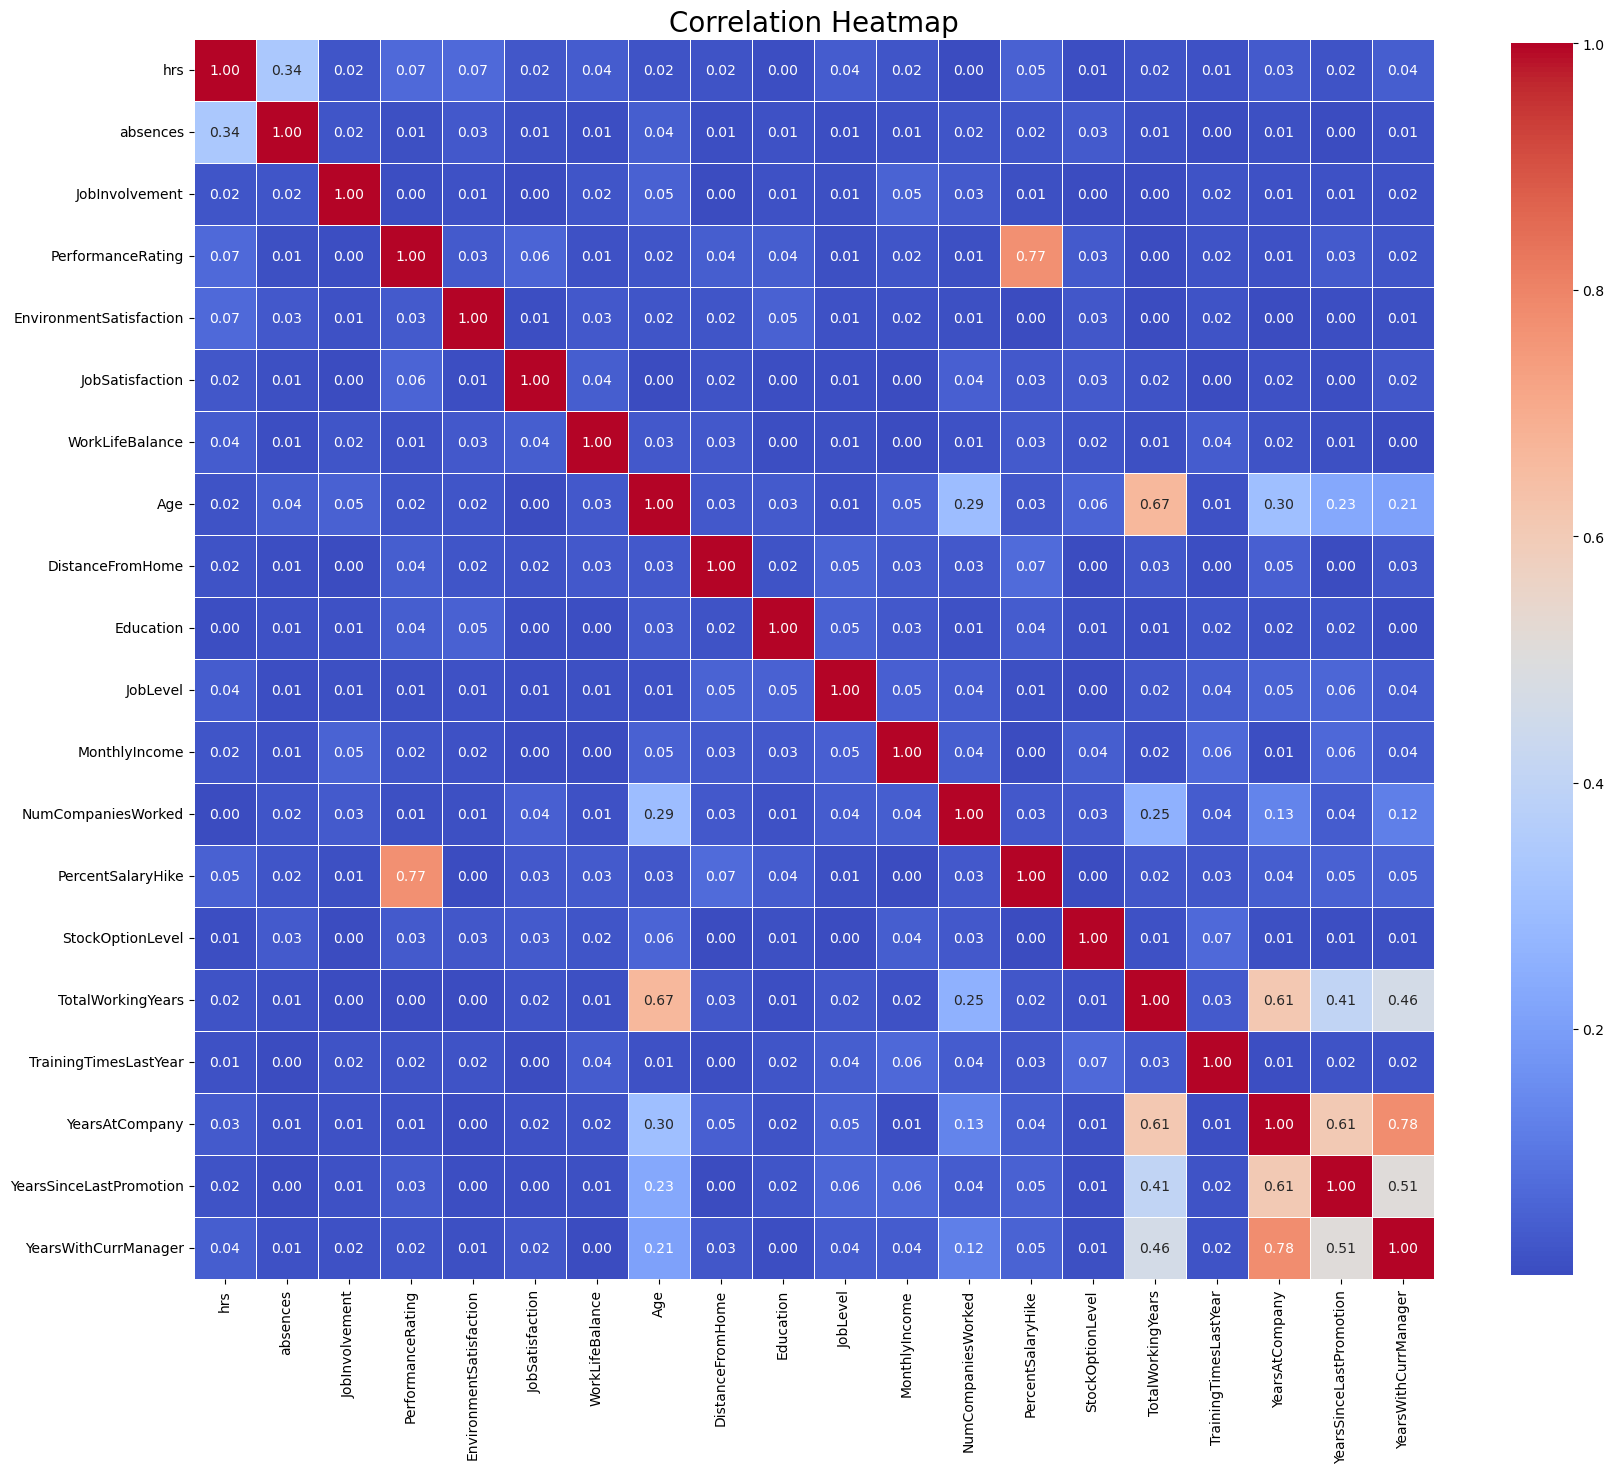

In [43]:
""" Seaborn correlation heatmap """

fig, ax = plt.subplots(figsize=(20, 20))

plt.title("Correlation Heatmap", fontsize=20)
sns.heatmap(
    correlation,
    square=True,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    ax=ax,
    cbar_kws={"shrink": 0.8},
)

Upon analyzing the correlation matrix of the dataset, we observe that most of the attributes are not correlated with each other, indicating that they contain unique information. However, there are a few attributes that exhibit a relatively high correlation, which we will investigate further.

- First, we note that `YearsAtCompany` and `YearsWithCurrManager` have a correlation coefficient of 0.78, which is considered a strong positive correlation. This implies that the longer an employee has been with the company, the longer they have likely been with their current manager.
- Similarly, `PercentSalaryHike` and `PerformanceRating` have a correlation coefficient of 0.77, indicating that employees who receive a higher salary hike are also more likely to receive a higher performance rating.
- `Age` and `TotalWorkingYears` are also relatively strongly correlated, with a correlation coefficient of 0.61, suggesting that older employees tend to have more years of working experience.
- Lastly, `TotalWorkingYears` and `YearsAtCompany` have a correlation coefficient of 0.61, indicating that employees who have worked longer in general are also likely to have spent more time with the company.

Despite these relatively high correlation coefficients, we choose not to delete any of these attributes. The are two **reasons** for this decission.
<br>**Firstly**, the correlation values are not high enough to suggest a strong linear relationship between the attributes, indicating that they may still contain unique information.
<br>**Secondly**, due to the small size of the dataset we are dealing with, the potential gain in performance from attribute deletion may not be significant compared to the loss of valuable information caused by their removal.
<br>Therefore, we will retain all the attributes in our analysis.

It is important to note that while correlation can provide useful insights, it does not necessarily imply causation.

---
# 4. Train-Test division 


**Note**: This division was already done before in *3.0. Dataset preparation*. We overwrite it to start from a clean state so there are no possible data contamination derived from the EDA process. Thus, no further explaination is needed.

## 4.1. Stratified K-Fold Train-Test split
To ensure a fair and unbiased evaluation of our model's performance, we will be using stratified k-fold for dividing our data into training and test sets. Stratified k-fold is a commonly used technique in machine learning that ensures that the distribution of classes in the training and test sets is similar, thus reducing the risk of introducing bias into our model's performance evaluation.

By using stratified k-fold, we can ensure that each fold of the data used for training and testing our model contains a representative sample of all the classes in the dataset. This helps to account for any potential class imbalance in the data, ensuring that our model is trained and tested on a diverse set of data, leading to a more reliable evaluation of its performance.

In [44]:
# Import the necessary libraries
from sklearn.model_selection import StratifiedKFold

In [45]:
""" Train Test Split using Stratified K-Fold """

# Make a copy of the data (we will re-split the data later to ensure that the data is not contaminated)
datos_copy = datos.copy()

# Define the number of folds for stratified k-fold
n_splits = 5

# Initialize the StratifiedKFold object
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over the stratified k-fold splits
for train_index, test_index in stratified_kfold.split(datos_copy, datos_copy['Attrition']):
    # Split the data into training and test sets using the current split indices
    train_set = datos_copy.iloc[train_index]
    test_set = datos_copy.iloc[test_index]
    
    # Extract the features (X) and target (y) from the training and test sets
    X_train = train_set.drop('Attrition', axis=1)  # Drop the 'Attrition' column to get the features
    y_train = train_set['Attrition']  # Extract the 'Attrition' column as the target
    
    X_test = test_set.drop('Attrition', axis=1)  # Drop the 'Attrition' column to get the features
    y_test = test_set['Attrition']  # Extract the 'Attrition' column as the target
 

In [46]:
print(f"{X_train.shape}, {y_train.shape}, {X_test.shape}, {y_test.shape}")

# Check is division summatory is correct
if X_train.shape[0] + X_test.shape[0] == datos_copy.shape[0]:
    print(
        f"\nThe train test division is correct: {X_train.shape[0]} + {X_test.shape[0]} = {datos_copy.shape[0]}"
    )
else:
    print("\nERROR: The train test division is incorrect")


(3528, 30), (3528,), (882, 30), (882,)

The train test division is correct: 3528 + 882 = 4410


In [47]:
# Check the train-test division correctness by comparing the class distribution in the original dataset and the train and test sets.
print("\n--------------------\n")
print("Original dataset class distribution:\n", datos_copy['Attrition'].value_counts(normalize=True))
print("\n--------------------\n")
print("Train set class distribution:\n", y_train.value_counts(normalize=True))
print("\n--------------------\n")
print("Test set class distribution:\n", y_test.value_counts(normalize=True))
print("\n--------------------\n")


--------------------

Original dataset class distribution:
 No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

--------------------

Train set class distribution:
 No     0.838719
Yes    0.161281
Name: Attrition, dtype: float64

--------------------

Test set class distribution:
 No     0.839002
Yes    0.160998
Name: Attrition, dtype: float64

--------------------



## 4.2. Dataset type subsets and cleaning

As before, we have already done the following steps in the EDA phase, so no further explaination is needed.

### 4.2.1. Attribute subsets

#### 4.2.1.1. Categorical and numerical attributes

In [48]:
# First of all, we divide our data-set into two general groups, categorical and numerical variables
X_train_str = X_train.select_dtypes(include=object)
X_train_num = X_train.select_dtypes(exclude=object)

#### 4.2.1.1. Ordinal and nominal attributes

In [49]:
# Next, we create a new subset of the ordinal variables
X_train_ordinals = X_train[['BusinessTravel']]

In [50]:
# Next, we take out the ordinal variables from the categorical variables group -> nominal group
X_train_nominal = X_train_str.drop('BusinessTravel', axis=1)

We print the column names of each subset to check that the division was done correctly.

In [51]:
# Print the columns of the two new data-sets
print("Numerical variables:", list(X_train_num.columns))
print("Categorical variables:", list(X_train_str.columns))
print("  - Ordinal variables:", list(X_train_ordinals.columns))
print("  - Nominal variables:", list(X_train_nominal.columns))

Numerical variables: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical variables: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']
  - Ordinal variables: ['BusinessTravel']
  - Nominal variables: ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']


### 4.2.2. Irrelevant and constant attributes

#### 4.2.2.1. Elimination of irrelevant attributes

In [52]:
# We take out the EmproyeeID column from the numerical variables group since its an identifier 
X_train_num = X_train_num.drop('EmployeeID', axis=1)
# X_train = X_train.drop('EmployeeID', axis=1)
print(list(X_train_num.columns))
print(len(list(X_train.columns)))

['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
30


#### 4.2.2.2. Elimination of constant attributes

##### 4.2.2.2.1. Constant numerical attributes

In [53]:
X_train_num = X_train_num.drop('StandardHours', axis=1)
# X_train = X_train.drop('StandardHours', axis=1)
print(list(X_train_num.columns))
print(len(list(X_train.columns)))

['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
30


In [54]:
X_train_num = X_train_num.drop('EmployeeCount', axis=1)
# X_train = X_train.drop('EmployeeCount', axis=1)
print(list(X_train_num.columns))
print(len(list(X_train.columns)))

['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
30


##### 4.2.2.2.2. Constant categorical attributes

In [55]:
X_train_nominal = X_train_nominal.drop ('Over18', axis=1)
# X_train = X_train.drop('Over18', axis=1)
print(list(X_train_nominal.columns))
print(len(list(X_train.columns)))

['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
30


In [56]:
# Print the columns of the two new data-sets
print("Numerical variables:", list(X_train_num.columns))
print("Categorical variables:", list(X_train_str.columns))
print("  - Ordinal variables:", list(X_train_ordinals.columns))
print("  - Nominal variables:", list(X_train_nominal.columns))

Numerical variables: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical variables: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']
  - Ordinal variables: ['BusinessTravel']
  - Nominal variables: ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']


## 4.3. Train-Test Error metrics

For classification problems, the most common metrics used to evaluate the performance of a model are accuracy, precision, recall, and F1 score. However, these metrics are not always the best choice for evaluating the performance of a model, especially when the dataset is imbalanced.<br>In this case, we will be using the following metrics to evaluate the performance of our models: **balanced accuracy, F1 score, and confusion matrix**.

Please note that for this evaluation, we have utilized the 5th fold generated during model training. This approach enables us to simulate test results without utilizing the actual test set, thereby providing an estimate of the model's accuracy once chosen. Specifically, we use the training data division of the 5th fold as our training data within the function, and the validation data of the 5th fold as our testing  partition. This method ensures an approximation to reliable and trustworthy results without needing to use the real test partition, enabling us to estimate the model's accuracy before deployment.

In [57]:
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix

np.random.seed(2)

def train_validation_test(model, estimators, X_train, y_train, folds_array, test = False, X_test = None, y_test = None, prints = True):
    
    # ? For every model, we will obtain the balanced_accuracy, the f1_score and the confusion matrix
    
    # Train
    y_train_pred = estimators.predict(X_train)
    balanced_accuracy_train = balanced_accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, pos_label='Yes')
    cm_train = confusion_matrix(y_train, y_train_pred)
     

    # Test
    if test:
        y_test_pred = estimators.predict(X_test)
        balanced_accuracy_test = balanced_accuracy_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, pos_label='Yes')
        cm_test = confusion_matrix(y_test, y_test_pred)
    
    # We retrain the model with the last obtained fold
    np.random.seed(2)
    
    X_train_fold, y_train_fold, X_validation_fold, y_validation_fold = folds_array[0], folds_array[2], folds_array[1], folds_array[3]

    model.fit(X = X_train_fold, y = y_train_fold)
    
    # Train in validation fold
    y_train_validation_pred = model.predict(X_train_fold)
    balanced_accuracy_train_validation = balanced_accuracy_score(y_train_fold, y_train_validation_pred)
    f1_train_validation = f1_score(y_train_fold, y_train_validation_pred, pos_label='Yes')
    cm_train_validation = confusion_matrix(y_train_fold, y_train_validation_pred)

    # Test in validation fold
    y_test_validation_pred = model.predict(X_validation_fold)
    balanced_accuracy_test_validation = balanced_accuracy_score(y_validation_fold, y_test_validation_pred)
    f1_test_validation = f1_score(y_validation_fold, y_test_validation_pred, pos_label='Yes')
    cm_test_validation = confusion_matrix(y_validation_fold, y_test_validation_pred)
    
    # ! Print results
    # Get the name of the model inside the estimators pipeline
    if prints:
        print("\n--------------------\n")
        print(f"MODEL: {model.best_estimator_.steps[-1][1]}")
        print(f"MODEL PARAMETERS: {model.best_params_}\n")
        # print(model)
        print("\n--------------------\n")
    
        print(f"TRAIN SET")
        print(f"Balanced accuracy in train set: {balanced_accuracy_train}")
        print(f"F1 score in train set: {f1_train}")
        print(f"Confusion matrix in train set:\n {cm_train}")
        print("\n--------------------\n")
        
        if test:
            print(f"TEST SET")
            print(f"Balanced accuracy in test set: {balanced_accuracy_test}")
            print(f"F1 score in test set: {f1_test}")
            print(f"Confusion matrix in test set:\n {cm_test}")
            print("\n--------------------\n")
        
        print(f"TRAIN VALIDATION SET")
        print(f"Balanced accuracy in train validation set: {balanced_accuracy_train_validation}")
        print(f"F1 score in train validation set: {f1_train_validation}")
        print(f"Confusion matrix in train validation set:\n {cm_train_validation}")
        print("\n--------------------\n")
        
        print(f"TEST VALIDATION SET")
        print(f"Balanced accuracy in test validation set: {balanced_accuracy_test_validation}")
        print(f"F1 score in test validation set: {f1_test_validation}")
        print(f"Confusion matrix in test validation set:\n {cm_test_validation}")
        print("\n--------------------\n")
        
    if test:
        return([[balanced_accuracy_train, f1_train, cm_train], [balanced_accuracy_train_validation, f1_train_validation, cm_train_validation], [balanced_accuracy_test_validation, f1_test_validation, cm_test_validation], [balanced_accuracy_test, f1_test, cm_test]])
    return([[balanced_accuracy_train, f1_train, cm_train], [balanced_accuracy_train_validation, f1_train_validation, cm_train_validation], [balanced_accuracy_test_validation, f1_test_validation, cm_test_validation]])
     

### 4.3.1. Print data distribution

In [58]:
def print_data_distribution(folds_array):
    """Print the split of the last fold to check the correct distribution of the data"""
    print(
        "Train:",
        folds_array[0].shape,
        "Train-y:",
        folds_array[2].shape,
        "Validation:",
        folds_array[1].shape,
        "Validation-y:",
        folds_array[3].shape,
        sep=" | ",
    )

    # Print the distribution of the target variable in the train and validation sets
    print(
        f"\nTrain-y:\n{folds_array[2].value_counts(normalize=True)}",
        f"Validation-y:\n{folds_array[3].value_counts(normalize=True)}\n",
        sep="\n\n",
    )

### 4.3.2. Print number of variables

In [59]:
def print_num_variables(pipeline):
    np.random.seed(2)
    """Print the number of selected variables in a pipeline with feature selection."""
    if "selector" not in pipeline.named_steps:
        # Print the name of the pipeline
        print(f"\nNO variable SELECTION in the pipline (selected all).\n")
        return 48  # Number of variables in dataset after preprocessing - only for the graphical plotting at the end - no importance, could be "all"
    print(f"\nVARIABLES SELECTION in the pipline {pipeline.named_steps['selector']}.")
    # Print the number of variables in the original dataset
    print(" - Number of variables in the original dataset:", X_train.shape[1])
    # Print the number of variables after feature selection    
    # print(" - Number of selected variables:", pipeline.named_steps["selector"].get_support())
    print(" - Number of variables after the preprocessing:", len(pipeline.named_steps["selector"].get_support()))
    print(" - Number of variables after selection:", np.sum(pipeline.named_steps["selector"].get_support()), "\n")
    return np.sum(pipeline.named_steps["selector"].get_support())

---
# 5. Model construction

In [60]:
# Three dictionaries to store the results of the models
models, results, times, variables = {}, {}, {}, {}

## 5.0. Previous considerations

### 5.0.1. Categorical variables

For the **categorical variables**, we will use **one-hot encoding** to transform them into numerical attributes. One-hot encoding is a commonly used technique for converting categorical attributes into numerical attributes that can be used by a machine learning model. One-hot encoding creates a new binary attribute for each possible category of each categorical attribute. The value of the new binary attribute is 1 if the instance has that category, and 0 otherwise. This increases the complexity of the dataset, but it is necessary for the model to be able to interpret the categorical attributes in sklearn.

Additionally, there is no need for scaling the data, as scales the features to have a mean of 0 and a standard deviation of 1, which is not applicable to categorical features that have been one-hot-encoded.

Note that we could also use label encoding to transform the categorical attributes into numerical attributes. However, one-hot encoding, is generally preferred over label encoding for categorical variables in machine learning because it avoids introducing false numerical relationships between categories.

#### 5.0.1.1. Nominal variables

As expected, we will use in the pipeline the **one-hot encoding** technique to transform the nominal variables into numerical attributes. Then we will use SimpleImputer to impute the missing values in the dataset, using the most frequent value for each attribute (as we are dealing with categorical attributes).

#### 5.0.1.1. Ordinal variables

As for for ordinal variables, the **ordinal encoding** technique will be used to transform the ordinal variables into numerical attributes. This is because **ordinal encoding** assigns a unique integer value to each category in a feature. It is useful when there is an inherent order or ranking to the categories. 

### 5.0.2. Numerical variables

For numerical attributes, we will use **IterativeImputer** to impute the missing values in the dataset. This imputer uses a machine learning model to estimate the missing values. It works by modeling each feature with missing values as a function of other features in a round-robin fashion.
The advantage is that it can **capture non-linear relationships** between features, and it is also able to impute missing values for multiple features simultaneously (which is not possible with SimpleImputer).
On the other hand, the disadvantage is that it is computationally expensive, but, as we are dealing with a relatively **small dataset**, this is not a problem.

Note that in sklearn, the IterativeImputer class is still experimental, so we will use the **IterativeImputer** class from the **sklearn.experimental** module.

Note also that the IterativeImputer in scikit-learn is designed to work with numerical data only. It uses a linear regression model to estimate missing values based on the other features in the dataset. Therefore, it is not appropriate to use IterativeImputer for imputing missing values in categorical data.

Additionally, we will use **StandardScaler** to scale the numerical attributes. This scaler standardizes features by removing the mean and scaling to unit variance. This is done to ensure that each attribute contributes approximately proportionately to the final distance. This is especially important for datasets with numerical attributes of different scales, as we have observed some of them in the EDA process.

### 5.0.3. Attribute selection

When selecting features for a machine learning model, there are several methods available to choose from. Three commonly used methods are f_classif, mutual_info_classif, and chi2. Each of these methods uses a different approach to select the most important features for the model.

The `f_classif` method is based on the ANOVA F-value and assumes that the features are normally distributed and there is a linear relationship between the features and the target variable. This means that it may not be the best choice for datasets that contain non-linear relationships between the features and the target variable. However, if the data does meet these assumptions, this method can be a reliable way to select the top k features with the highest scores.

On the other hand, the `mutual_info_classif` method estimates the mutual information between each feature and the target variable, which can capture non-linear relationships and does not assume any specific distribution for the features. This method is useful when the relationship between the features and the target variable is not linear or when the data contains non-normally distributed features.

Finally, the `chi2` method is suitable for datasets with categorical features and assumes that the features are independent of each other. This method computes the chi-squared statistic between each feature and the target variable, and selects the top k features with the highest scores. However, it may not be the best choice for datasets that contain continuous features or non-independent categorical features.

The `mutual_info_classif` method is a suitable choice for selecting features in a machine learning model when the relationships between the features and the target variable are non-linear or when the data contains non-normally distributed features. Unlike the f_classif method, it does not assume any specific distribution for the features and can capture non-linear relationships between the features and the target variable. Additionally, it can handle continuous as well as categorical features.

Therefore, if the dataset contains non-linear relationships or non-normally distributed features (as it is our case), the `mutual_info_classif` method may be a more appropriate, and it is the one we are going to use.

### 5.0.4. Model validation split obtention
The validation split for the models was obtained using the 5th (last) fold of the StratifiedKFold cross-validation method. We chose the 5th fold arbitrarily, since the nature of StratifiedKFold ensures that all folds are representative of the data distribution.

In [61]:
""" StratifieldKFold that stores the last split as the validation set """
np.random.seed(2)

# We could use whatever split due to the nature of StratifiedKFold, so the decision is arbitrary
def stratified_kfold_last_split(folds_array):
    np.random.seed(2)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    for train_index, test_index in skf.split(X_train, y_train):
        # Note that the target variable is "Attrition"
        # Extract the features (X) and target (y) from the training and test sets
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    # Insert the folds in the array
    # This is possible because python passes data by reference so we do not need to return the array (not possible in cv)
    folds_array.append(X_train_fold); folds_array.append(X_val_fold); folds_array.append(y_train_fold); folds_array.append(y_val_fold)

## 5.1. Pipelines construction

In [62]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

We have structured it in a way that lets us use three different pipelines, one for each attribute data type (non-ordinal object, ordinal object, numerical). These pipelines provide a solution for the missing values identified during the EDA section. All pipelines have a two-step process: first, we impute the missing values, and then we scale/encode the results.

**Pipeline 1: Imputation**

1. For numerical variables, we have chosen to impute missing values using `IterativeImputer`. This imputer provides a powerful and flexible approach to imputing missing values in datasets with complex patterns of missing data and mixed data types. The `IterativeImputer` uses a regression model to estimate missing values, which allows it to take into account the relationships between variables in the dataset. This method can help preserve the structure and relationships of the data while filling in missing values.

2. For categorical variables (ordinal and non-ordinal), we have decided to use `SimpleImputer` as it is the most recommended method for categorical variables. It is the most commonly used method for imputation which works by replacing missing values with the most frequent value (for the most_frequent strategy) or a constant value specified by the user (for the constant strategy).<br>We also considered using `KNNImputer`, but this method works best when there are large numbers of options, but it may not be the best choice when there are only a few options.<br>Since we do not have a lot of categories nor instances, we have decided to use `SimpleImputer` for categorical variables.

**Pipeline 2: Scaling/Encoding**

1. For numerical variables, we have decided to use `StandardScaler()` to normalize the scale of the numerical features and prevent any large differences in magnitude from dominating the model fitting process. This ensures that each feature contributes equally to the logistic regression model and improves the stability and convergence of the optimization algorithm.

2. For non-ordinal categorical variables, we have decided to use `OneHotEncoder`. This encoder creates binary variables for each category in the original variable, which can help avoid assumptions about the underlying structure of the data and improve the accuracy of the model. Other encoders, such as `LabelEncoder` or `OrdinalEncoder`, are not recommended for nominal categorical variables as they can introduce spurious order or hierarchy to the categories. Additionally, these encoders may not be suitable for logistic regression models as they assume a linear relationship between the encoded values and the target variable, which may not be appropriate for categorical variables.

3. For ordinal categorical variables, we have decided to use `OrdinalEncoder` since it preserves the order of the categories and converts them into numerical values that can be used in the logistic regression model. This ensures that the model can accurately capture the relationship between the ordinal categories and the target variable. Additionally, the `OrdinalEncoder` can handle missing values in the ordinal variables, which is important for ensuring that the imputation process does not introduce bias into the model.

In [63]:
def triple_pipeline():
    """ Triple pipeline for numerical, categorical and ordinal categorical variables """
    np.random.seed(2)
    # ? Pipeline for numerical values (X_train_num)
    imputer_num = IterativeImputer(
        random_state=2,
        missing_values=np.nan,
    )
    pipeline_lr_num = Pipeline(
        steps=[
            ("imputer", imputer_num),  # ? Imputation with IterativeImputer
            ("scaler", StandardScaler()),  # ? Standard scaling
        ]
    )

    # ? One hot encoding the categorical variables
    imputer_cat = SimpleImputer(strategy="most_frequent")
    pipeline_lr_cat = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),  # ? One hot encoding
            ("imputer", imputer_cat),  # ? Imputation with SimpleImputer
        ]
    )

     # ? We add a second pipeline for ordinal categorical variables 
    imputer_cat_ord = SimpleImputer(strategy="most_frequent")
    pipeline_lr_cat_ord = Pipeline(
        steps=[
            ("encoder", OrdinalEncoder(handle_unknown='error')),  # ? Ordinal encoding
            ("imputer", imputer_cat_ord)  # ? Imputation with SimpleImputer
        ]
    )

    return [pipeline_lr_num, pipeline_lr_cat, pipeline_lr_cat_ord]

def triple_pipeline_feature():
    """ Triple pipeline for numerical, categorical and ordinal categorical variables with feature selection """
    np.random.seed(2)
    # ? Pipeline for numerical values (X_train_num)
    imputer_num = IterativeImputer(
        random_state=2,
        missing_values=np.nan,
    )
    pipeline_lr_num = Pipeline(
        steps=[
            ("imputer", imputer_num),  # ? Imputation with IterativeImputer
            ("scaler", StandardScaler()),  # ? Standard scaling
        ]
    )

    # ? One hot encoding the categorical variables
    imputer_cat = SimpleImputer(strategy="most_frequent")
    pipeline_lr_cat = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),  # ? One hot encoding
            ("imputer", imputer_cat),  # ? Imputation with SimpleImputer
        ]
    )

    # ? We add a second pipeline for ordinal categorical variables 
    imputer_cat_ord = SimpleImputer(strategy="most_frequent")
    pipeline_lr_cat_ord = Pipeline(
        steps=[
            ("encoder", OrdinalEncoder(handle_unknown='error')),  # ? Ordinal encoding
            ("imputer", imputer_cat_ord),  # ? Imputation with SimpleImputer
        ]
    )
    
    return [pipeline_lr_num, pipeline_lr_cat, pipeline_lr_cat_ord]

In [64]:
""" Pipelines with and without selection of parameters """

pipeline = triple_pipeline()
pipeline_num = pipeline[0]
pipeline_cat = pipeline[1]
pipeline_cat_ord = pipeline[2]

pipeline_feature = triple_pipeline_feature()
pipeline_num_feature = pipeline_feature[0]
pipeline_cat_feature = pipeline_feature[1]
pipeline_cat_ord_feature = pipeline_feature[2]

Note that in this pipeline, we have included the sub-pipelines for different attribute data types, and have dropped all the attributes that were considered not useful for the model during the exploratory data analysis (EDA) process. These attributes include "Over18", "EmployeeCount", and "StandardHours", which have constant values, and "EmployeeID", which is a unique identifier for each employee. Including this drop in the pipeline provides a simple way of droping more attributes if needed in the future in a simple way.

In [65]:
np.random.seed(2)
# ? Pipeline for numerical values (X_train_num)
imputer_num = IterativeImputer(
    random_state=2,
    missing_values=np.nan,
)
pipeline_lr_num = Pipeline(
    steps=[
        ("imputer", imputer_num),  # ? Imputation with IterativeImputer
        ("scaler", StandardScaler()),  # ? Standard scaling
    ]
)
# ? One hot encoding the categorical variables
imputer_cat = SimpleImputer(strategy="most_frequent")
pipeline_lr_cat = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),  # ? One hot encoding
        ("imputer", imputer_cat),  # ? Imputation with SimpleImputer
    ]
)
# ? We add a second pipeline for ordinal categorical variables 
imputer_cat_ord = SimpleImputer(strategy="most_frequent")
pipeline_lr_cat_ord = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(handle_unknown='error')),  # ? Ordinal encoding
        ("imputer", imputer_cat_ord),  # ? Imputation with SimpleImputer
    ]
)

In [66]:
""" Column transformer to apply the pipelines to the correct columns """

np.random.seed(2)

preprocessor = ColumnTransformer(
    transformers=[
        # Drop the columns before applying the pipelines
        ("drop_over18", "drop", ["Over18"]), # ? We drop the column "Over18" because it is constant
        ("drop_employeeid", "drop", ["EmployeeID"]), # ? We drop the column "EmployeeID" because it is a unique identifier 
        ("drop_standardhours", "drop", ["StandardHours"]), # ? We drop the column "StandardHours" because it is constant
        ("drop_employeecount", "drop", ["EmployeeCount"]), # ? We drop the column "EmployeeCount" because it is constant
        ("num", pipeline_num, X_train_num.columns), # X_train_num.columns for numerical values
        ("cat", pipeline_cat, X_train_nominal.columns), # X_train_nominal.columns for categorical values (not ordinals)
        ("ord", pipeline_cat_ord, X_train_ordinals.columns)  # X_train_ordinals.columns for categorical ordinal values 
    ]
)

preprocessor_feature = ColumnTransformer(
    transformers=[
        # Drop columns before feature selection with the pipelines
        ("drop_over18", "drop", ["Over18"]),  # ? We drop the column "Over18" because it is constant
        ("drop_employeeid", "drop", ["EmployeeID"]), # ? We drop the column "EmployeeID" because it is a unique identifier 
        ("drop_standardhours", "drop", ["StandardHours"]), # ? We drop the column "StandardHours" because it is constant  
        ("drop_employeecount", "drop", ["EmployeeCount"]), # ? We drop the column "EmployeeCount" because it is constant
        ("num", pipeline_num_feature, X_train_num.columns), # X_train_num.columns for numerical values
        ("cat", pipeline_cat_feature, X_train_nominal.columns), # X_train_nominal.columns for categorical values (not ordinals)
        ("ord", pipeline_cat_ord_feature, X_train_ordinals.columns)  # X_train_ordinals.columns for categorical ordinal values
    ]
)

### 5.1.1. Important remarks about the selection of features models

Stratified k-fold cross-validation is a powerful technique used for splitting data into k-folds while maintaining the same class proportions in each fold as in the original data. This is particularly useful when dealing with class imbalance or uneven target variable distributions.

However, since the splits are random, each time cross-validation is run, a different set of folds is generated, potentially leading to different performance scores due to different subsets of the data being used for training and validation. Although setting a random seed and state helps, slight variations may still occur. While this may not be a problem in most cases, it can significantly impact the plots of parameters with similar results, especially when cross-validation is used for feature selection or hyperparameter tuning (e.g. selecting the best selector k for the SelectKBest method, which has very little variance).

To address this issue, we will use a fixed test validation set (of the 5th k fold) for both evaluation and plotting. This ensures that the model is evaluated on the same data every time, enabling us to compare performance across different models and parameters and reproduce results. Evaluating the model with a fixed test set also helps to identify overfitting or underfitting issues.

We will analyze the k_best features for each model and plot them beforehand, selecting the best features for each model. This approach can help overcome the reproducibility issues in cross-validation splits.

It is important to note that the scikit-learn developers have acknowledged these issues with reproducibility in the stratified cross-validation splits, and there are open pull requests addressing them. These issues were introduced in scikit-learn version 0.19 and have not yet been fully resolved in the latest version.

## 5.2. Logistic Regression
Logistic regression with no hyperparameter tuning. It will be used as a baseline for the rest of the models.

In [67]:
from sklearn.linear_model import LogisticRegression

In [68]:
np.random.seed(2)

preprocessing_pipeline_lr = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(random_state=2, class_weight='balanced')),        
    ]
)

preprocessing_pipeline_feature_lr = Pipeline(
    steps = [
        ("preprocessor", preprocessor_feature), # ? Preprocessing with feature selection
        ("selector", SelectKBest(mutual_info_classif)), # ? Feature selection
        ("model", LogisticRegression(random_state=100451170, class_weight='balanced', max_iter=1000)), # ? Logistic regression
    ] 
)

### 5.2.1. Logistic Regression - Predefined parameters

#### 5.2.1.1. Logistic Regression - Predefined parameters - No attribute selection

In [69]:
""" Logistic Regression with the default parameters """

np.random.seed(2)

param_grid_lr = {
    "model__penalty": ["l2"],
    "model__C": [1.0],
    "model__fit_intercept": [True],
    "model__solver": ["lbfgs"],
    "model__max_iter": [100],
    "model__multi_class": ["auto"],
}

folds_array_lr = []

model_lr = GridSearchCV(
    preprocessing_pipeline_lr,
    param_grid_lr,
    cv=stratified_kfold_last_split(folds_array_lr),
    scoring="balanced_accuracy",
    n_jobs=-1,
)

start_time = time.time()
model_lr.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

print_data_distribution(folds_array_lr)

# Print the best model and its performance
print(
    "Logistic regression score in the kfolds (balanced accuracy):",
    model_lr.best_score_,
)

score = train_validation_test(model_lr, model_lr.best_estimator_, X_train, y_train, folds_array_lr) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["Logistic_Regression"] = model_lr
results["Logistic_Regression"] = score
times["Logistic_Regression"] = time_lr
variables["Logistic_Regression"] = print_num_variables(model_lr.best_estimator_) # ? Print the number of variables used in the model

Train: | (2823, 30) | Train-y: | (2823,) | Validation: | (705, 30) | Validation-y: | (705,)

Train-y:
No     0.83847
Yes    0.16153
Name: Attrition, dtype: float64

Validation-y:
No     0.839716
Yes    0.160284
Name: Attrition, dtype: float64

Logistic regression score in the kfolds (balanced accuracy): 0.6942486127177492

--------------------

MODEL: LogisticRegression(class_weight='balanced', random_state=2)
MODEL PARAMETERS: {'model__C': 1.0, 'model__fit_intercept': True, 'model__max_iter': 100, 'model__multi_class': 'auto', 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


--------------------

TRAIN SET
Balanced accuracy in train set: 0.7079996626419294
F1 score in train set: 0.43841562669560497
Confusion matrix in train set:
 [[2089  870]
 [ 165  404]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 0.7224654236986636
F1 score in train validation set: 0.45592286501377416
Confusion matrix in train validation set:
 [[1702  665]
 [ 125  331]]

#### 5.2.1.2. Logistic Regression - Predefined parameters - Attribute selection

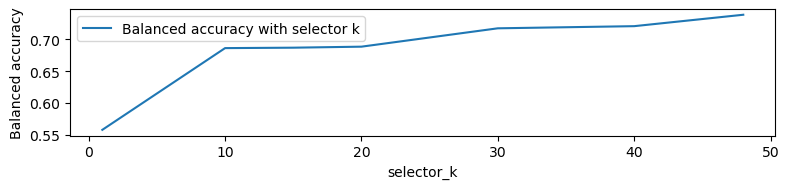

The best k-value is 48 with a balanced accuracy of 0.7388180433955082


In [120]:
np.random.seed(2)

plt.rcParams['figure.figsize'] = [10, 2]

a_selector_k = [1, 10, 15, 20, 30, 40, 48] # 48 is the number of variables after preprocessing
features6 = []

for i in a_selector_k:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_feature_lr,
        {"selector__k": [i]},
        cv=stratified_kfold_last_split(folds_array),
        # cv = StratifiedKFold(n_splits=4),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    score = train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0] # Balance accuracy in test validation - constant seed
    features6.append(score)


fig6, ax6 = plt.subplots()

# ax6.plot(a_selector_k, balanced6, label="Balanced accuracy")

ax6.plot(a_selector_k, features6, label="Balanced accuracy with selector k")
ax6.set_xlabel("selector_k")
ax6.set_ylabel("Balanced accuracy")
ax6.legend()

plt.tight_layout()
plt.show()

print(f"The best k-value is {a_selector_k[np.argmax(features6)]} with a balanced accuracy of {np.max(features6)}")

As it can be observed, the optimal k value for the selector of attributes is 48, which is all the attributes (after preprocessing), but in order to choose a good value that has a good balance between performance and number of attributes, we will choose the value of 30, which is the one that has the best performance with the least number of attributes.

In [104]:
""" Logistic Regression with the default parameters and feature selection """

np.random.seed(2)

param_grid_lr = {
    "model__penalty": ["l2"],
    "model__C": [1.0],
    "model__fit_intercept": [True],
    "model__solver": ["lbfgs"],
    "model__max_iter": [100],
    "model__multi_class": ["auto"],
    "selector__k": [30], # This is the best k-value found in the previous cell
}

folds_array_feature_lr = []

model_lr = GridSearchCV(
    preprocessing_pipeline_feature_lr,
    param_grid_lr,
    cv=stratified_kfold_last_split(folds_array_feature_lr),
    scoring="balanced_accuracy",
    n_jobs=-1,
)


start_time = time.time()
model_lr.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time


print_data_distribution(folds_array_feature_lr)

# Print the best model and its performance
print(
    "Logistic regression score in the kfolds (balanced accuracy):",
    model_lr.best_score_,
)

score = train_validation_test(model_lr, model_lr.best_estimator_, X_train, y_train, folds_array_feature_lr) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["Logistic_Regression_k"] = model_lr
results["Logistic_Regression_k"] = score
times["Logistic_Regression_k"] = time_lr
variables["Logistic_Regression_k"] = print_num_variables(model_lr.best_estimator_) # ? Print the number of variables used in the model

Train: | (3528, 30) | Train-y: | (3528,) | Validation: | (882, 30) | Validation-y: | (882,)

Train-y:
No     0.838719
Yes    0.161281
Name: Attrition, dtype: float64

Validation-y:
No     0.839002
Yes    0.160998
Name: Attrition, dtype: float64

Logistic regression score in the kfolds (balanced accuracy): 0.7006909094280684

--------------------

MODEL: LogisticRegression(class_weight='balanced', random_state=100451170)
MODEL PARAMETERS: {'model__C': 1.0, 'model__fit_intercept': True, 'model__max_iter': 100, 'model__multi_class': 'auto', 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'selector__k': 30}


--------------------

TRAIN SET
Balanced accuracy in train set: 0.7093124724095804
F1 score in train set: 0.43825042881646653
Confusion matrix in train set:
 [[2589 1110]
 [ 200  511]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 0.7048229731343
F1 score in train validation set: 0.43361884368308345
Confusion matrix in train validation set:
 

## 5.3. Boosting

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
preprocessing_pipeline_gb = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
        ("model", GradientBoostingClassifier(random_state=2)),        
    ]
)

preprocessing_pipeline_feature_gb = Pipeline(
    steps = [
        ("preprocessor", preprocessor_feature),
        ("selector", SelectKBest(mutual_info_classif)),  # ? Feature selection with mutual_info_classif
        ("model", GradientBoostingClassifier(random_state=2)),
    ]
)

### 5.3.1. Boosting - Predefined parameters

#### 5.3.1.1. Boosting - Predefined parameters - No attribute selection

In [74]:
""" Gradient boosting with the default parameters """

np.random.seed(2)

param_grid_gb = {
    "model__n_estimators": [100],
    "model__learning_rate": [0.1],
    "model__max_depth": [3],
    "model__subsample": [1.0],
    "model__min_samples_split": [2],
}

folds_array_gb = []

model_gb = GridSearchCV(
    preprocessing_pipeline_gb,
    param_grid_gb,
    cv=stratified_kfold_last_split(folds_array_gb),
    scoring="balanced_accuracy",
    n_jobs=-1,
)

start_time = time.time()
model_gb.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

print_data_distribution(folds_array_gb)

# Print the best model and its performance
print(
    "Boosting score in the kfolds (balanced accuracy):",
    model_gb.best_score_,
)

score = train_validation_test(model_gb, model_gb.best_estimator_, X_train, y_train, folds_array_gb) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["Gradient_boosting"] = model_gb
results["Gradient_boosting"] = score
times["Gradient_boosting"] = time_lr
variables["Gradient_boosting"] = print_num_variables(model_gb.best_estimator_) # ? Print the number of variables used in the model

Train: | (2823, 30) | Train-y: | (2823,) | Validation: | (705, 30) | Validation-y: | (705,)

Train-y:
No     0.83847
Yes    0.16153
Name: Attrition, dtype: float64

Validation-y:
No     0.839716
Yes    0.160284
Name: Attrition, dtype: float64

Boosting score in the kfolds (balanced accuracy): 0.6454592468273019

--------------------

MODEL: GradientBoostingClassifier(random_state=2)
MODEL PARAMETERS: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_samples_split': 2, 'model__n_estimators': 100, 'model__subsample': 1.0}


--------------------

TRAIN SET
Balanced accuracy in train set: 0.7080237172226641
F1 score in train set: 0.5811138014527846
Confusion matrix in train set:
 [[2942   17]
 [ 329  240]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 0.7323255064149601
F1 score in train validation set: 0.6284875183553599
Confusion matrix in train validation set:
 [[2356   11]
 [ 242  214]]

--------------------

TEST VALIDATION SET
B

#### 5.3.1.2. Boosting - Predefined parameters - Attribute selection

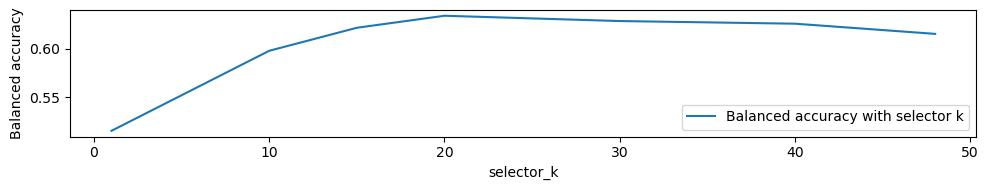

The best k-value is 20 with a balanced accuracy of 0.6341933747907199


In [75]:
np.random.seed(2)

plt.rcParams['figure.figsize'] = [10, 2]

a_selector_k = [1, 10, 15, 20, 30, 40, 48] # 48 is the number of variables after preprocessing
features6 = []

for i in a_selector_k:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_feature_gb,
        {"selector__k": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    score = train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0] # Balance accuracy in test validation - constant seed
    features6.append(score)


fig6, ax6 = plt.subplots()

ax6.plot(a_selector_k, features6, label="Balanced accuracy with selector k")
ax6.set_xlabel("selector_k")
ax6.set_ylabel("Balanced accuracy")
ax6.legend()

plt.tight_layout()
plt.show()

print(f"The best k-value is {a_selector_k[np.argmax(features6)]} with a balanced accuracy of {np.max(features6)}")

In [76]:
""" Gradient boosting with the default parameters """

np.random.seed(2)

param_grid_gb = {
    "model__n_estimators": [100],
    "model__learning_rate": [0.1],
    "model__max_depth": [3],
    "model__subsample": [1.0],
    "model__min_samples_split": [2],
    "selector__k": [20], # Best k-value for this model
}

folds_array_feature_gb = []

model_gb = GridSearchCV(
    preprocessing_pipeline_feature_gb,
    param_grid_gb,
    cv=stratified_kfold_last_split(folds_array_feature_gb),
    scoring="balanced_accuracy",
    n_jobs=-1,
)

start_time = time.time()
model_gb.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

print_data_distribution(folds_array_feature_gb)

# Print the best model and its performance
print(
    "Boosting score in the kfolds (balanced accuracy):",
    model_gb.best_score_,
)


score = train_validation_test(model_gb, model_gb.best_estimator_, X_train, y_train, folds_array_feature_gb) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["Gradient_boosting_k"] = model_gb
results["Gradient_boosting_k"] = score
times["Gradient_boosting_k"] = time_lr
variables["Gradient_boosting_k"] = print_num_variables(model_gb.best_estimator_) # ? Print the number of variables used in the model

Train: | (2823, 30) | Train-y: | (2823,) | Validation: | (705, 30) | Validation-y: | (705,)

Train-y:
No     0.83847
Yes    0.16153
Name: Attrition, dtype: float64

Validation-y:
No     0.839716
Yes    0.160284
Name: Attrition, dtype: float64

Boosting score in the kfolds (balanced accuracy): 0.620732304836098

--------------------

MODEL: GradientBoostingClassifier(random_state=2)
MODEL PARAMETERS: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_samples_split': 2, 'model__n_estimators': 100, 'model__subsample': 1.0, 'selector__k': 20}


--------------------

TRAIN SET
Balanced accuracy in train set: 0.6593892155890313
F1 score in train set: 0.4775353016688061
Confusion matrix in train set:
 [[2935   24]
 [ 383  186]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 0.6891801747715296
F1 score in train validation set: 0.5415384615384615
Confusion matrix in train validation set:
 [[2349   18]
 [ 280  176]]

--------------------

TES

### 5.3.2. Boosting - Selected parameters

In [77]:
from sklearn.model_selection import RandomizedSearchCV

The five most important parameters of sklearn Gradient Boosting are:

1. `n_estimators`: This parameter controls the number of boosting stages to perform during the training process. Each stage adds a new tree to the ensemble, and the algorithm tries to improve the model's performance by adjusting the weights of the trees. Increasing the number of estimators would increase the complexity of the model and its ability to capture complex relationships in the data, but it might also increase the risk of overfitting.

2. `learning_rate`: This parameter controls the step size at which the gradient boosting algorithm learns. A smaller learning rate would make the algorithm learn slowly, but it might eventually converge to a better solution. A larger learning rate would make the algorithm learn faster, but it might also overshoot the optimal solution.

3. `max_depth`: This parameter controls the maximum depth of the decision trees used in the gradient boosting algorithm. A deeper tree would be able to capture more complex relationships in the data, but it might also overfit the training data. A shallower tree would be less likely to overfit, but it might not capture all the relevant patterns in the data.

4. `subsample`: This parameter controls the fraction of samples to be used for fitting the individual base learners. A value less than 1.0 leads to a reduction in variance and an increase in the bias of the model. This parameter can be used to speed up the training process and/or to handle overfitting.

5. `min_samples_split`: This parameter controls the minimum number of samples required to split an internal node. A smaller value leads to more complex trees, which can fit the training data better but might overfit. A larger value would create simpler trees and reduce the risk of overfitting, but the model might not capture all the relevant patterns in the data.

It is important to take into account that gradient boosting algorithms work by iteratively adding weak learners (e.g., decision trees) to the model to improve the overall predictive accuracy. Each weak learner is trained on a subset of the features, with the remaining features left out. During each iteration, the algorithm evaluates the contribution of each feature to the overall prediction performance, and assigns a weight to each feature based on its importance.

This process of feature weighting effectively performs a type of feature selection, in which less important features are assigned smaller weights and therefore have less influence on the final predictions. As a result, the SelectKBest feature selection method may not be necessary in many cases, since gradient boosting already performs a form of feature selection during its learning process.

Although knowing this, for the sake of completeness, we will also perform feature selection using SelectKBest and compare the results with the default feature weighting method of gradient boosting.

#### 5.3.2.1. Parameter analysis

The best k-value is 20 with a balanced accuracy of 0.6341933747907199


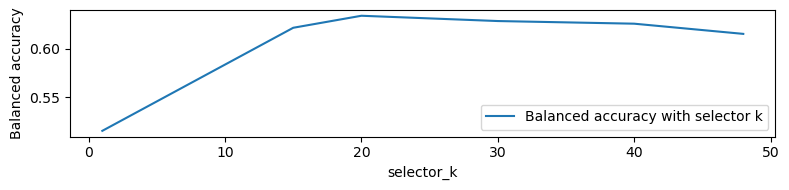

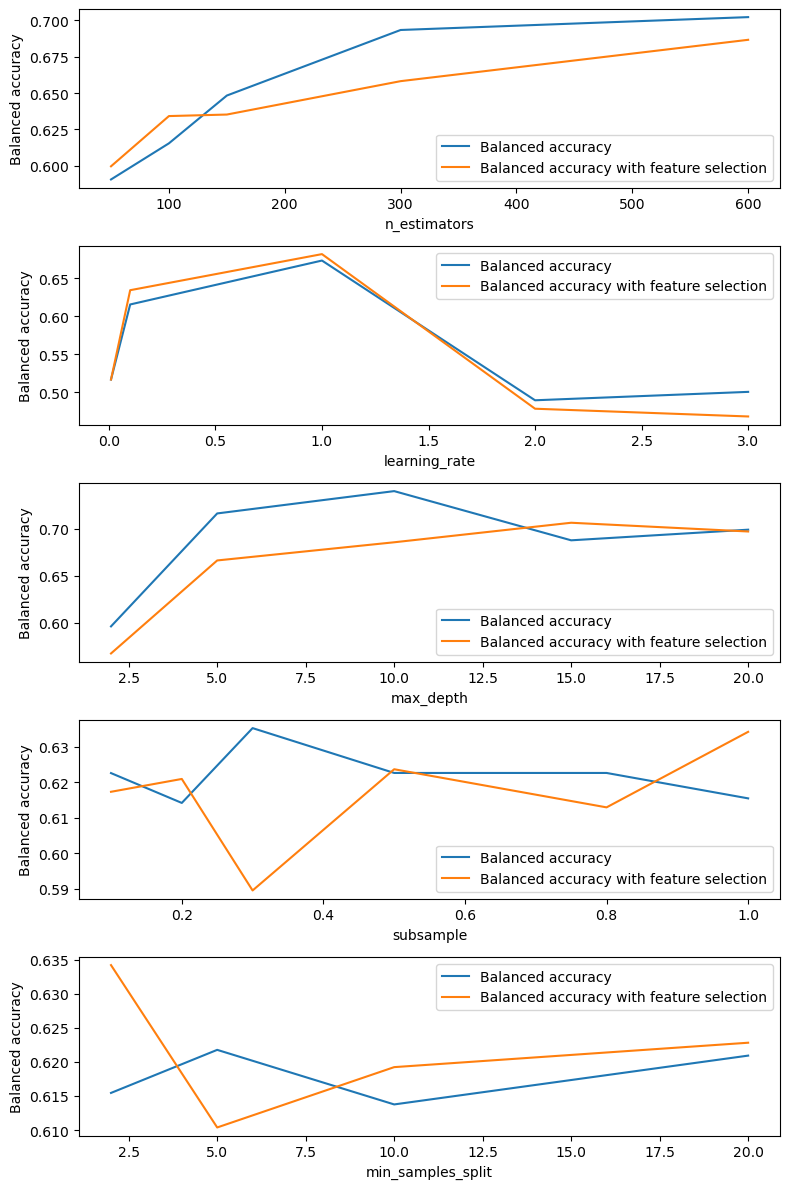

In [78]:
""" Study of the parameters of the Gradient Boosting Classifier """

np.random.seed(2)

balanced, balanced2, balanced3, balanced4, balanced5 = [], [], [], [], []
features, features2, features3, features4, features5, features6 = [], [], [], [], [], []

a_n_estimators = [50, 100, 150, 300, 600]  # Number of boosting stages - The more the better score (ad infinitum) but the longer the training
a_learning_rate = [0.01, 0.1, 1.0, 2.0, 3.0] # Learning rate
a_max_depth = [2, 5, 10, 15, 20] # Maximum depth of the individual regression estimators
a_subsample = [0.1, 0.2, 0.3, 0.5, 0.8, 1.0]  # The fraction of samples to be used for fitting the individual base learners
a_min_samples_split = [2, 5, 10, 20] # The minimum number of samples required to split an internal node
a_selector_k = [1, 15, 20, 30, 40, 48] # 48 is the number of variables after preprocessing

for i in a_selector_k:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_feature_gb,
        {"selector__k": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train) 
    features6.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
print(f"The best k-value is {a_selector_k[np.argmax(features6)]} with a balanced accuracy of {np.max(features6)}")

best_k = a_selector_k[np.argmax(features6)]

# ! We will use the last split of the stratified kfold to ensure reproducibility
# ! With the encountered selector k-value

for i in a_n_estimators:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_gb,
        {"model__n_estimators": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    balanced.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    model_feature = GridSearchCV(
        preprocessing_pipeline_feature_gb,
        {"model__n_estimators": [i],
         "selector__k": [best_k]}, # Best k-value for this model viewed above (20)
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model_feature.fit(X_train, y_train)
    features.append(train_validation_test(model_feature, model_feature.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    
for i in a_learning_rate:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_gb,
        {"model__learning_rate": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy", 
        n_jobs=-1,
    )
    model.fit(X_train, y_train) 
    balanced2.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    model_feature = GridSearchCV( 
        preprocessing_pipeline_feature_gb,
        {"model__learning_rate": [i],
        "selector__k": [best_k]}, # Best k-value for this model viewed above (20)
        cv=stratified_kfold_last_split(folds_array), 
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model_feature.fit(X_train, y_train)
    features2.append(train_validation_test(model_feature, model_feature.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    
for i in a_max_depth:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_gb,
        {"model__max_depth": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    balanced3.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    model_feature = GridSearchCV(
        preprocessing_pipeline_feature_gb,
        {"model__max_depth": [i],
        "selector__k": [best_k]}, # Best k-value for this model viewed above (20)
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model_feature.fit(X_train, y_train)
    features3.append(train_validation_test(model_feature, model_feature.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])

for i in a_subsample:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_gb,
        {"model__subsample": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    balanced4.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    model_feature = GridSearchCV(
        preprocessing_pipeline_feature_gb,
        {"model__subsample": [i],
        "selector__k": [best_k]}, # Best k-value for this model viewed above (20)
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model_feature.fit(X_train, y_train)
    features4.append(train_validation_test(model_feature, model_feature.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
     
    
for i in a_min_samples_split:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_gb,
        {"model__min_samples_split": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    balanced5.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    model_feature = GridSearchCV(
        preprocessing_pipeline_feature_gb,
        {"model__min_samples_split": [i],
         "selector__k": [best_k]}, # Best k-value for this model viewed above (20)
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model_feature.fit(X_train, y_train)
    features5.append(train_validation_test(model_feature, model_feature.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    

fig6, ax6 = plt.subplots()
ax6.plot(a_selector_k, features6, label="Balanced accuracy with selector k")
ax6.set_xlabel("selector_k") 
ax6.set_ylabel("Balanced accuracy") 
ax6.legend()

plt.tight_layout()
plt.rcParams['figure.figsize'] = [8, 2]
plt.show()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 12))

ax1.plot(a_n_estimators, balanced, label="Balanced accuracy")
ax1.plot(a_n_estimators, features, label="Balanced accuracy with feature selection")
ax1.set_xlabel("n_estimators")
ax1.set_ylabel("Balanced accuracy")
ax1.legend()

ax2.plot(a_learning_rate, balanced2, label="Balanced accuracy")
ax2.plot(a_learning_rate, features2, label="Balanced accuracy with feature selection")
ax2.set_xlabel("learning_rate")
ax2.set_ylabel("Balanced accuracy")
ax2.legend()

ax3.plot(a_max_depth, balanced3, label="Balanced accuracy")
ax3.plot(a_max_depth, features3, label="Balanced accuracy with feature selection")
ax3.set_xlabel("max_depth")
ax3.set_ylabel("Balanced accuracy")
ax3.legend()

ax4.plot(a_subsample, balanced4, label="Balanced accuracy")
ax4.plot(a_subsample, features4, label="Balanced accuracy with feature selection")
ax4.set_xlabel("subsample")
ax4.set_ylabel("Balanced accuracy")
ax4.legend()

ax5.plot(a_min_samples_split, balanced5, label="Balanced accuracy")
ax5.plot(a_min_samples_split, features5, label="Balanced accuracy with feature selection")
ax5.set_xlabel("min_samples_split")
ax5.set_ylabel("Balanced accuracy")
ax5.legend()

plt.tight_layout()
plt.rcParams['figure.figsize'] = [10, 3]
plt.show()


In the above graphs, we can clearly observe the dataset parameters elbows, which are the points where the dataset parameters stop improving exponentially. We will try to use these parameters to improve the model's performance, situating the parameters around the elbow points because they assure us that the model will have a balance between performance and score (this is because we could improve the model by increasing some parameters ad infinitum (such as n_stimators), but this would lead to an enormous computational cost).

The last graph shows a trend where increasing the value of **k** leads to **better model performance**. This is to be expected, as a higher k value allows the model to utilize more informative features. However, it is important to find a balance between model performance and computational cost. Selecting all 48 variables will increase the computational cost, while selecting too few may result in a less informative model. Based on the graph, it appears that selecting 20 variables strikes a good balance between model performance and computational cost. Additionally, it should be noted that the pipeline already removes constant and irrelevant variables detected during the EDA, so the selected features are likely to be informative (which is one of the reasons why it performs the best with all the variables).

Based on the above analysis, we will be deciding which ranges we choose for the parameter selection of both models with and without attribute selection (as the interrelation of parameters changes the final result, as can be clearly seen).

#### 5.3.2.1. Boosting - Selected parameters - No attribute selection

In [79]:
""" Gradient boosting with the default parameters """

np.random.seed(2)

budget = 50

param_grid_gb = {
    "model__n_estimators": [100, 150, 200, 250],  # Number of boosting stages - The more the better score (ad infinitum)
    "model__learning_rate": [0.5, 1.0, 1.5],
    "model__max_depth": [5, 7, 10, 15],
    "model__subsample": [0.3, 0.4, 0.5],  # < 1.0 leads to a reduction of variance and an increase of bias
    "model__min_samples_split": [2, 3, 5, 7],
}

folds_array_select_gb = []

model_gb = RandomizedSearchCV(
    preprocessing_pipeline_gb,
    param_grid_gb,
    cv=stratified_kfold_last_split(folds_array_select_gb),
    scoring="balanced_accuracy",
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model_gb.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

print_data_distribution(folds_array_select_gb)

# Print the best model and its performance
print(
    "Boosting score in the kfolds (balanced accuracy):",
    model_gb.best_score_,
)

score = train_validation_test(model_gb, model_gb.best_estimator_, X_train, y_train, folds_array_select_gb) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")


models["Gradient_boosting_select"] = model_gb
results["Gradient_boosting_select"] = score
times["Gradient_boosting_select"] = time_lr
variables["Gradient_boosting_select"] = print_num_variables(model_gb.best_estimator_) # ? Print the number of variables used in the model

Train: | (2823, 30) | Train-y: | (2823,) | Validation: | (705, 30) | Validation-y: | (705,)

Train-y:
No     0.83847
Yes    0.16153
Name: Attrition, dtype: float64

Validation-y:
No     0.839716
Yes    0.160284
Name: Attrition, dtype: float64

Boosting score in the kfolds (balanced accuracy): 0.7627639007574031

--------------------

MODEL: GradientBoostingClassifier(learning_rate=0.5, max_depth=15, n_estimators=200,
                           random_state=2, subsample=0.5)
MODEL PARAMETERS: {'model__subsample': 0.5, 'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__max_depth': 15, 'model__learning_rate': 0.5}


--------------------

TRAIN SET
Balanced accuracy in train set: 0.9956740360794953
F1 score in train set: 0.988646288209607
Confusion matrix in train set:
 [[2949   10]
 [   3  566]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 0.9920229915727214
F1 score in train validation set: 0.9772972972972972
Confusion matrix in t

#### 5.3.2.2. Boosting - Selected parameters - Attribute selection

In [80]:
""" Gradient boosting with the default parameters """

np.random.seed(2)

budget = 50

param_grid_gb = {
    "model__n_estimators": [100, 150, 200, 250],  # Number of boosting stages - The more the better score (ad infinitum)
    "model__learning_rate": [0.5, 1.0, 1.5],
    "model__max_depth": [5, 7, 10, 15],
    "model__subsample": [0.3, 0.4, 0.5],  # < 1.0 leads to a reduction of variance and an increase of bias
    "model__min_samples_split": [2, 3, 7, 10],
    "selector__k": [20],
}

folds_array_feature_select_gb = []

model_gb = RandomizedSearchCV(
    preprocessing_pipeline_feature_gb,
    param_grid_gb,
    cv=stratified_kfold_last_split(folds_array_feature_select_gb),
    scoring="balanced_accuracy",
    n_iter=budget,
    random_state=2,
    n_jobs=-1,
)

start_time = time.time()
model_gb.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

print_data_distribution(folds_array_feature_select_gb)

# Print the best model and its performance
print(
    "Boosting score in the kfolds (balanced accuracy):",
    model_gb.best_score_,
)

score = train_validation_test(model_gb, model_gb.best_estimator_, X_train, y_train, folds_array_feature_select_gb) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["Gradient_boosting_select_k"] = model_gb
results["Gradient_boosting_select_k"] = score
times["Gradient_boosting_select_k"] = time_lr
variables["Gradient_boosting_select_k"] = print_num_variables(model_gb.best_estimator_) # ? Print the number of variables used in the model

Train: | (2823, 30) | Train-y: | (2823,) | Validation: | (705, 30) | Validation-y: | (705,)

Train-y:
No     0.83847
Yes    0.16153
Name: Attrition, dtype: float64

Validation-y:
No     0.839716
Yes    0.160284
Name: Attrition, dtype: float64

Boosting score in the kfolds (balanced accuracy): 0.7321471065796018

--------------------

MODEL: GradientBoostingClassifier(learning_rate=0.5, max_depth=15, n_estimators=200,
                           random_state=2, subsample=0.5)
MODEL PARAMETERS: {'selector__k': 20, 'model__subsample': 0.5, 'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__max_depth': 15, 'model__learning_rate': 0.5}


--------------------

TRAIN SET
Balanced accuracy in train set: 0.9958091574897947
F1 score in train set: 0.9929701230228472
Confusion matrix in train set:
 [[2955    4]
 [   4  565]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 0.9936725924443555
F1 score in train validation set: 0.9901207464324918
C

## 5.4. CatBoost

### 5.4.1. CatBoost - Predefined parameters

#### 5.4.1.0. Model selection (external libraries)

When it comes to selecting a machine learning model for a specific task, external libraries such as `LightGBM`, `XGBoost`, and `CatBoost` offer a wide range of options to choose from.

- `LightGBM` is a great option for handling large datasets with many features efficiently. It uses a histogram-based algorithm, which speeds up the training process significantly. Additionally, it provides many hyperparameters that can be tuned to improve performance, including some that are specific to handling categorical features.

- `XGBoost` is a popular choice for prioritizing model accuracy over training speed. It offers several regularization techniques that can help prevent overfitting and improve model performance. Additionally, XGBoost has a large and active user community, which can be helpful if users run into any issues or have questions.

- `CatBoost` is a newer library that offers similar functionality to XGBoost and LightGBM, but with some unique features that make it a compelling choice in certain scenarios. For example, it has built-in support for handling categorical features and can automatically handle missing values. This feature can save time and effort in data preprocessing and potentially improve model performance.

However, in the case where categorical features have already been one-hot encoded (or ordinal encoded), there may not be any significant advantage to using CatBoost over XGBoost or LightGBM. In such cases, any of the three libraries could be used. 

The choice of the appropriate machine learning algorithm depends on the characteristics of the dataset and the goals of the project. When dealing with a large dataset with many features, or when training speed is prioritized over accuracy, `LightGBM` is a better choice due to its efficiency and scalability. It uses a histogram-based algorithm to speed up the training process, which can be several times faster than traditional gradient boosting algorithms. On the other hand, if model accuracy is a priority and the dataset is small, then `XGBoost` could be a better option, as it provides many regularization techniques that can help prevent overfitting and improve model performance.

However, in this current dataset, `CatBoost` is a better choice because the target variable 'Attrition' is a nominal variable, which complicates and downgrades the use of the other two methods. One-hot encoding of the `y_train` (and `X_test` and `y_test` at the end) dataset would lead to an increase in the number of features and potentially increase the complexity of the model. `CatBoost` has built-in support for handling categorical features, which eliminates the need for one-hot encoding, and it can automatically handle missing values. This can save time and effort in data preprocessing and potentially improve model performance. Additionally, it is worth noting that CatBoost is the newest library and offers very good performance in terms of accuracy and speed, as evidenced by the official CatBoost documentation (https://catboost.ai/en/docs/).

In [81]:
from catboost import CatBoostClassifier

In [82]:
""" Append classifier to preprocessing pipeline """

preprocessing_pipeline_cat = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
        ("model", CatBoostClassifier(verbose=False, random_state=2))
    ]
)

preprocessing_pipeline_feature_cat = Pipeline(
    steps = [
        ("preprocessor", preprocessor_feature),
        ("selector", SelectKBest(mutual_info_classif)), # ? Feature selection with mutual_info_classif
        ("model", CatBoostClassifier(verbose=False, random_state=2))
    ]
)

#### 5.4.1.1. CatBoost - Predefined parameters - No attribute selection

In [83]:
""" CatBoost Classifier with the default parameters """

np.random.seed(2)

param_grid_cat = {}  # No parameters to tune

folds_array_cat = []

model_cat = GridSearchCV(
    preprocessing_pipeline_cat,
    param_grid=param_grid_cat,
    cv=stratified_kfold_last_split(folds_array_cat),
    scoring="balanced_accuracy",
    n_jobs=-1,
)

start_time = time.time()
model_cat.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

print_data_distribution(folds_array_cat)

# Print the best model and its performance
print(
    "Boosting score in the kfolds (balanced accuracy):",
    model_cat.best_score_,
)

score = train_validation_test(model_cat, model_cat.best_estimator_, X_train, y_train, folds_array_cat) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["CatBoost"] = model_cat
results["CatBoost"] = score
times["CatBoost"] = time_lr
variables["CatBoost"] = print_num_variables(model_cat.best_estimator_) # ? Print the number of variables used in the model

Train: | (2823, 30) | Train-y: | (2823,) | Validation: | (705, 30) | Validation-y: | (705,)

Train-y:
No     0.83847
Yes    0.16153
Name: Attrition, dtype: float64

Validation-y:
No     0.839716
Yes    0.160284
Name: Attrition, dtype: float64

Boosting score in the kfolds (balanced accuracy): 0.7313898951965377

--------------------

MODEL: <catboost.core.CatBoostClassifier object at 0x7fbcac639600>
MODEL PARAMETERS: {}


--------------------

TRAIN SET
Balanced accuracy in train set: 0.9437609841827768
F1 score in train set: 0.9404096834264433
Confusion matrix in train set:
 [[2959    0]
 [  64  505]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 0.9429824561403508
F1 score in train validation set: 0.9395348837209303
Confusion matrix in train validation set:
 [[2367    0]
 [  52  404]]

--------------------

TEST VALIDATION SET
Balanced accuracy in test validation set: 0.6976276608466874
F1 score in test validation set: 0.5542168674698795
Confu

#### 5.4.1.2. CatBoost - Predefined parameters - Attribute selection

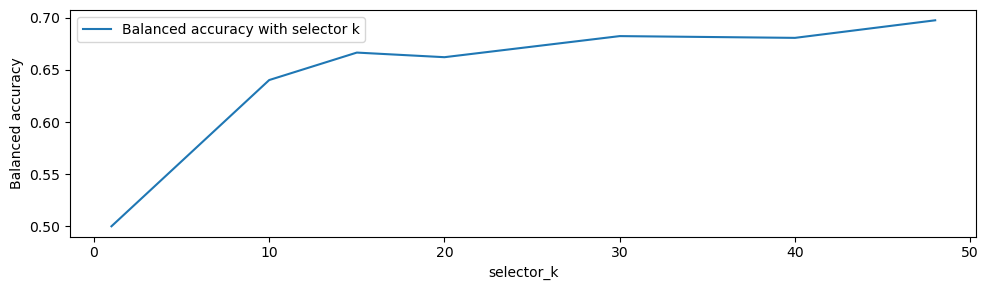

The best k-value is 48 with a balanced accuracy of 0.6976276608466874


In [84]:
np.random.seed(2)

a_selector_k = [1, 10, 15, 20, 30, 40, 48] # 48 is the number of variables after preprocessing
features6 = []

for i in a_selector_k:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_feature_cat,
        {"selector__k": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    score = train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0] # Balance accuracy in test validation - constant seed
    features6.append(score)


fig6, ax6 = plt.subplots()

ax6.plot(a_selector_k, features6, label="Balanced accuracy with selector k")
ax6.set_xlabel("selector_k")
ax6.set_ylabel("Balanced accuracy")
ax6.legend()

plt.tight_layout()
plt.rcParams['figure.figsize'] = [8, 2]
plt.show()

print(f"The best k-value is {a_selector_k[np.argmax(features6)]} with a balanced accuracy of {np.max(features6)}")

As the best k-value is 48 (which are all the attributes after preprocessing), there is no necessity to perform the CatBoost algorithm with attribute selection at first glance, but we will perform it with k = 30 as it is one of the best values and reduces the number of variables by 37.5 % so it will offer a good balance between computational cost and performance (which is the main reason why we perform attribute selection). Unlike the other attribute performance plots, we will need to fixate it by hand as otherwise, it will choose the best k-value of 48, which does not make sense.

Also, is important to notice that this plot only serves us as a stimation of which single value performs better in the model, but as we will see in the next section, the interrelation of parameters changes the final result, if not, the graphs for feature selection and no feature selection would have the same shape.

In [128]:
""" CatBoost Classifier with the default parameters and feature selection """

np.random.seed(2)
selected_k = 30

param_grid_cat = {
    "selector__k": [selected_k],
}

folds_array_feature_cat = []

model_cat = GridSearchCV(
    preprocessing_pipeline_feature_cat,
    param_grid=param_grid_cat,
    cv=stratified_kfold_last_split(folds_array_feature_cat),
    scoring="balanced_accuracy",
    n_jobs=-1,
)

start_time = time.time()
model_cat.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

print_data_distribution(folds_array_feature_cat)

# Print the best model and its performance
print(
    "Boosting score in the kfolds (balanced accuracy):",
    model_cat.best_score_,
)

score = train_validation_test(model_cat, model_cat.best_estimator_, X_train, y_train, folds_array_feature_cat) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["CatBoost_k"] = model_cat
results["CatBoost_k"] = score
times["CatBoost_k"] = time_lr
variables["CatBoost_k"] = print_num_variables(model_cat.best_estimator_) # ? Print the number of variables used in the model

Train: | (3528, 30) | Train-y: | (3528,) | Validation: | (882, 30) | Validation-y: | (882,)

Train-y:
No     0.838719
Yes    0.161281
Name: Attrition, dtype: float64

Validation-y:
No     0.839002
Yes    0.160998
Name: Attrition, dtype: float64

Boosting score in the kfolds (balanced accuracy): 0.7479538872102101

--------------------

MODEL: <catboost.core.CatBoostClassifier object at 0x7fbc985f8310>
MODEL PARAMETERS: {'selector__k': 30}


--------------------

TRAIN SET
Balanced accuracy in train set: 0.916747940770855
F1 score in train set: 0.9081163859111792
Confusion matrix in train set:
 [[3697    2]
 [ 118  593]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 0.9172299695130461
F1 score in train validation set: 0.9090909090909091
Confusion matrix in train validation set:
 [[2958    1]
 [  94  475]]

--------------------

TEST VALIDATION SET
Balanced accuracy in test validation set: 0.750142748382185
F1 score in test validation set: 0.65753

### 5.4.2. CatBoost - Selected parameters

The four most important parameters of CatBoostClassifier are:

1. `learning_rate`: This is the step size at which the gradient boosting algorithm learns. A smaller learning rate would make the algorithm learn slowly, but it might eventually converge to a better solution. A larger learning rate would make the algorithm learn faster, but it might also overshoot the optimal solution.

2. `depth`: This is the maximum depth of the decision trees used in the gradient boosting algorithm. A deeper tree would be able to capture more complex relationships in the data, but it might also overfit the training data. A shallower tree would be less likely to overfit, but it might not capture all the relevant patterns in the data.

3. `l2_leaf_reg`: This is the regularization parameter that controls the amount of L2 regularization applied to the weights of the model. L2 regularization helps to prevent overfitting by penalizing large weights in the model. A larger value of `l2_leaf_reg` would increase the amount of regularization, while a smaller value would decrease it.

4. `iterations`: This is the number of boosting iterations to perform during the training process. Each iteration adds a new decision tree to the ensemble, and the algorithm tries to improve the model's performance by adjusting the weights of the trees. Increasing the number of iterations would increase the complexity of the model, but it might also increase the risk of overfitting.

The selected k-value is 30


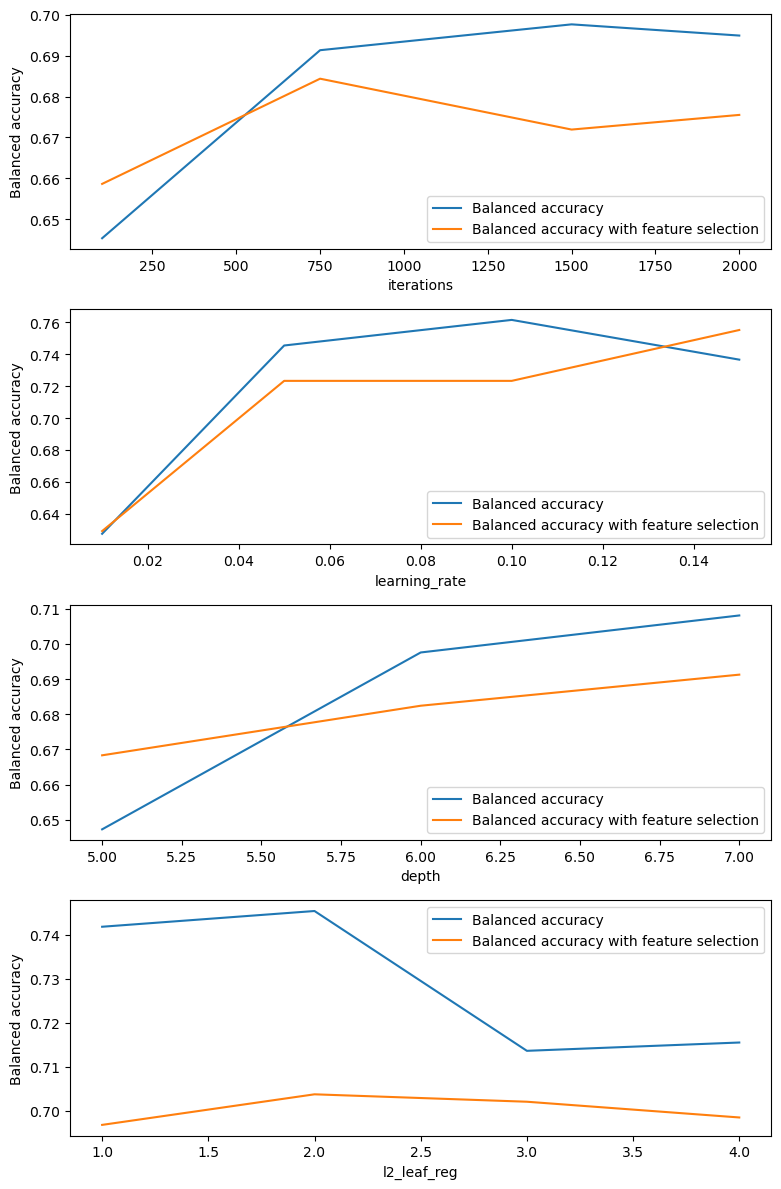

In [86]:
""" Study of the parameters of CatBoost """

np.random.seed(2)

balanced, balanced2, balanced3, balanced4 = [], [], [], []
features, features2, features3, features4 = [], [], [], []

a_iterations = [100, 750, 1500, 2000] # Default 1000 - The more the better score (ad infinitum) but the longer the training
a_learning_rate = [0.01, 0.05, 0.1, 0.15] # Default 0.1 - The more the better score (ad infinitum) but the longer the training
a_depth = [5, 6, 7] # Default 6
a_l2_leaf_reg = [1, 2, 3, 4] # Default 3

selected_k = 30 # Value selected from the previous study as a good balance between score and number of variables
print(f"The selected k-value is {selected_k}")

# ! We will use the last split of the stratified kfold to ensure reproducibility
# ! With the encountered selector k-value

for i in a_iterations:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_cat,
        {"model__iterations": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    balanced.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    model_feature = GridSearchCV(
        preprocessing_pipeline_feature_cat,
        {"model__iterations": [i],
         "selector__k": [selected_k]}, # Value selected from the previous study as a good balance between score and number of variables
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model_feature.fit(X_train, y_train)
    features.append(train_validation_test(model_feature, model_feature.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])


for i in a_learning_rate:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_cat,
        {"model__learning_rate": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    balanced2.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    model_feature = GridSearchCV(
        preprocessing_pipeline_feature_cat,
        {"model__learning_rate": [i],
         "selector__k": [selected_k]}, # Value selected from the previous study as a good balance between score and number of variables
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model_feature.fit(X_train, y_train)
    features2.append(train_validation_test(model_feature, model_feature.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])

for i in a_depth:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_cat,
        {"model__depth": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    balanced3.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    model_feature = GridSearchCV(
        preprocessing_pipeline_feature_cat,
        {"model__depth": [i],
         "selector__k": [selected_k]}, # Value selected from the previous study as a good balance between score and number of variables
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model_feature.fit(X_train, y_train)
    features3.append(train_validation_test(model_feature, model_feature.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])

for i in a_l2_leaf_reg:
    folds_array = []
    model = GridSearchCV(
        preprocessing_pipeline_cat,
        {"model__l2_leaf_reg": [i]},
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    balanced4.append(train_validation_test(model, model.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])
    model_feature = GridSearchCV(
        preprocessing_pipeline_feature_cat,
        {"model__l2_leaf_reg": [i],
          "selector__k": [selected_k]}, # Value selected from the previous study as a good balance between score and number of variables
        cv=stratified_kfold_last_split(folds_array),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    model_feature.fit(X_train, y_train)
    features4.append(train_validation_test(model_feature, model_feature.best_estimator_, X_train, y_train, folds_array, None, None, None, False)[2][0])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 12))

ax1.plot(a_iterations, balanced, label="Balanced accuracy")
ax1.plot(a_iterations, features, label="Balanced accuracy with feature selection")
ax1.set_xlabel("iterations")
ax1.set_ylabel("Balanced accuracy")
ax1.legend()

ax2.plot(a_learning_rate, balanced2, label="Balanced accuracy")
ax2.plot(a_learning_rate, features2, label="Balanced accuracy with feature selection")
ax2.set_xlabel("learning_rate")
ax2.set_ylabel("Balanced accuracy")
ax2.legend()

ax3.plot(a_depth, balanced3, label="Balanced accuracy")
ax3.plot(a_depth, features3, label="Balanced accuracy with feature selection")
ax3.set_xlabel("depth")
ax3.set_ylabel("Balanced accuracy")
ax3.legend()

ax4.plot(a_l2_leaf_reg, balanced4, label="Balanced accuracy")
ax4.plot(a_l2_leaf_reg, features4, label="Balanced accuracy with feature selection")
ax4.set_xlabel("l2_leaf_reg")
ax4.set_ylabel("Balanced accuracy")
ax4.legend()

plt.tight_layout()
plt.rcParams['figure.figsize'] = [8, 3]
plt.show()

Similarly as with Boosting, some parameters such as `learning_rate`, `ìterations`, and `depth` can be increased *ad infinitum*, but this would lead to a **enormous** computational cost. Therefore, we will try to use these parameters to improve the model's performance, situating the parameters around the elbow points because they assure us that the model will have a balance between performance and score.

#### 5.4.2.1. CatBoost - Selected parameters - No attribute selection

Selecting parameters in a model such as Catboost can be a challenging task, as the number of parameters is high and the possible combinations are even higher. Therefore, we will use the elbow points of the graphs to select the best-fitting parameters for the model. Note that the tested values for the model are commented on in the code. To lower computational costs and allow the project's reviewer to reproduce the results in a reasonable time, we have decided to maintain only the best value for each parameter in the code.

In [87]:
""" CatBoost Classifier  with selection of parameters """

np.random.seed(2)

budget = 4

param_grid_cat = {
    'model__iterations': [1500, 2000],# 1000, 1500  # ? Number of trees
    'model__learning_rate': [0.075, 0.1], # [0.075, 0.1, 0.15], as we can observe in the plot, the value 0.1 is the best
    'model__depth': [8],
    'model__l2_leaf_reg': [2] # [1, 3, 5, 7, 9] -> As we can observe in the plot, the value 2 is the best 
}

folds_array_select_cat = []

model_cat = RandomizedSearchCV(
    preprocessing_pipeline_cat,
    param_grid_cat,
    cv=stratified_kfold_last_split(folds_array_select_cat),
    scoring="balanced_accuracy",
    n_iter=budget,
    random_state=2,
    n_jobs=-1,
)

start_time = time.time()
model_cat.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

print_data_distribution(folds_array_select_cat)

# Print the best model and its performance
print(
    "Boosting score in the kfolds (balanced accuracy):",
    model_cat.best_score_,
)

score = train_validation_test(model_cat, model_cat.best_estimator_, X_train, y_train, folds_array_select_cat) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["CatBoost_select"] = model_cat
results["CatBoost_select"] = score
times["CatBoost_select"] = time_lr
variables["CatBoost_select"] = print_num_variables(model_cat.best_estimator_) # ? Print the number of variables used in the model

Train: | (2823, 30) | Train-y: | (2823,) | Validation: | (705, 30) | Validation-y: | (705,)

Train-y:
No     0.83847
Yes    0.16153
Name: Attrition, dtype: float64

Validation-y:
No     0.839716
Yes    0.160284
Name: Attrition, dtype: float64

Boosting score in the kfolds (balanced accuracy): 0.816961683467967

--------------------

MODEL: <catboost.core.CatBoostClassifier object at 0x7fbcabe3e110>
MODEL PARAMETERS: {'model__learning_rate': 0.075, 'model__l2_leaf_reg': 2, 'model__iterations': 2000, 'model__depth': 8}


--------------------

TRAIN SET
Balanced accuracy in train set: 1.0
F1 score in train set: 1.0
Confusion matrix in train set:
 [[2959    0]
 [   0  569]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 1.0
F1 score in train validation set: 1.0
Confusion matrix in train validation set:
 [[2367    0]
 [   0  456]]

--------------------

TEST VALIDATION SET
Balanced accuracy in test validation set: 0.7772736785458024
F1 score in test v

#### 5.4.2.2. CatBoost - Selected parameters - Attribute selection

In [88]:
""" CatBoost Classifier  with selection of parameters """

np.random.seed(2)

budget = 4

folds_array_feature_select_cat = []

param_grid_cat = {
    'model__iterations': [750, 2000],# 1000, 1500  # ? Number of trees
    'model__learning_rate': [0.1, 0.15], # [0.075, 0.1, 0.15], as we can observe in the plot, the value 0.15 is the best for the feature selection
    'model__depth': [8],
    'model__l2_leaf_reg': [2], # [1, 3, 5, 7, 9] -> As we can observe in the plot, the value 2 is the best for the feature selection
    'selector__k': [selected_k], # Value selected from the previous study as a good balance between score and number of variables
}

model_cat = RandomizedSearchCV(
    preprocessing_pipeline_feature_cat,
    param_grid_cat,
    cv=stratified_kfold_last_split(folds_array_feature_select_cat),
    scoring="balanced_accuracy",
    n_iter=budget,
    random_state=2,
    n_jobs=-1,
)

start_time = time.time()
model_cat.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

print_data_distribution(folds_array_feature_select_cat)

# Print the best model and its performance
print(
    "Boosting score in the kfolds (balanced accuracy):",
    model_cat.best_score_,
)

score = train_validation_test(model_cat, model_cat.best_estimator_, X_train, y_train, folds_array_feature_select_cat) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["CatBoost_select_k"] = model_cat
results["CatBoost_select_k"] = score
times["CatBoost_select_k"] = time_lr
variables["CatBoost_select_k"] = print_num_variables(model_cat.best_estimator_) # ? Print the number of variables used in the model

Train: | (2823, 30) | Train-y: | (2823,) | Validation: | (705, 30) | Validation-y: | (705,)

Train-y:
No     0.83847
Yes    0.16153
Name: Attrition, dtype: float64

Validation-y:
No     0.839716
Yes    0.160284
Name: Attrition, dtype: float64

Boosting score in the kfolds (balanced accuracy): 0.7896100678427098

--------------------

MODEL: <catboost.core.CatBoostClassifier object at 0x7fbcabf7feb0>
MODEL PARAMETERS: {'selector__k': 30, 'model__learning_rate': 0.15, 'model__l2_leaf_reg': 2, 'model__iterations': 2000, 'model__depth': 8}


--------------------

TRAIN SET
Balanced accuracy in train set: 1.0
F1 score in train set: 1.0
Confusion matrix in train set:
 [[2959    0]
 [   0  569]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 1.0
F1 score in train validation set: 1.0
Confusion matrix in train validation set:
 [[2367    0]
 [   0  456]]

--------------------

TEST VALIDATION SET
Balanced accuracy in test validation set: 0.7258655226022482

## 5.5. Conclusions

During this section, we will use several measurements to compare the performance of different models and their parameters. These measurements include the Balanced Accuracy Score, F1 Score, and Confusion Matrix. The Balanced Accuracy Score is obtained directly from the model training, while the other three scores are calculated using the 5th fold of the training set. We have chosen to use these 5th fold in order to avoid using the test set, which should only be used at the end of the project to test the final model. By doing so, we can obtain an accurate assessment of the model's performance without risking the integrity of the test set. These measurements allow for a robust comparison of the different models and their parameters

#### Balanced Accuracy

MODEL SCORES (Balanced Accuracy Test Validation):
    0. Logistic_Regression: 0.6509507294905525
    1. Logistic_Regression_k: 0.7174438523030072
    2. Gradient_boosting: 0.6154478593637885
    3. Gradient_boosting_k: 0.6341933747907199
    4. Gradient_boosting_select: 0.7129947978952403
    5. Gradient_boosting_select_k: 0.7049898349677111
    6. CatBoost: 0.6976276608466874
    7. CatBoost_k: 0.750142748382185
    8. CatBoost_select: 0.7772736785458024
    9. CatBoost_select_k: 0.7258655226022482


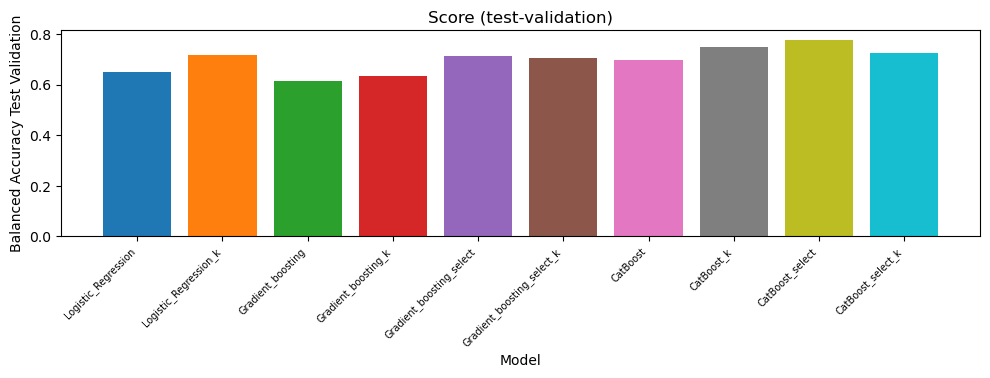

In [140]:
print("MODEL SCORES (Balanced Accuracy Test Validation):")

# Make the following plot taller
plt.rcParams['figure.figsize'] = [10, 3]

iter = 0
for key, value in results.items():
    # If the model is the "selected_model"
    if key == "selected_model":
        continue
    plt.bar(key, abs(value[2][0]))
    print(f"    {iter}. {key}: {abs(value[2][0])}")
    iter += 1

plt.title("Score (test-validation)")
plt.xlabel("Model")
plt.ylabel("Balanced Accuracy Test Validation")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/balanced_accuracy.png")
plt.show()


After analyzing the balanced accuracy results, it is evident that the CatBoost model with selected parameters and no attribute selection performed the best with a score of 0.77. However, it is important to note that this model requires the longest training time, which necessitates a trade-off between training time and accuracy. Conversely, the worst-performing model was the gradient boosting model with predefined parameters and attribute selection, scoring only 0.61. This is a considerable difference of 0.16 compared to the best model, emphasizing the significance of selecting the right model with the appropriate parameters to achieve the highest possible accuracy.

#### F1 Score

MODEL SCORES (F1 Test Validation):
    0. Logistic_Regression: 0.3773584905660377
    1. Logistic_Regression_k: 0.439918533604888
    2. Gradient_boosting: 0.3708609271523179
    3. Gradient_boosting_k: 0.4125
    4. Gradient_boosting_select: 0.5698324022346368
    5. Gradient_boosting_select_k: 0.5568181818181819
    6. CatBoost: 0.5542168674698795
    7. CatBoost_k: 0.6575342465753424
    8. CatBoost_select: 0.6956521739130435
    9. CatBoost_select_k: 0.6117647058823529


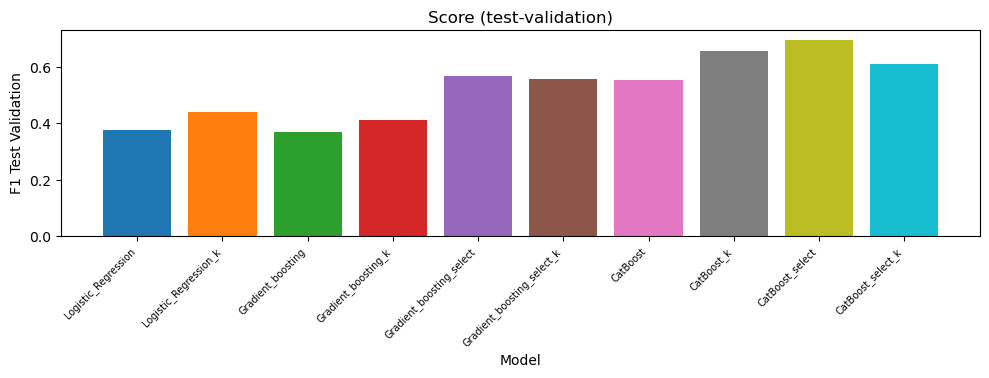

In [139]:
print("MODEL SCORES (F1 Test Validation):")

# Make the following plot taller
plt.rcParams['figure.figsize'] = [10, 3]

iter = 0
for key, value in results.items():
    # If the model is the "selected_model"
    if key == "selected_model":
        continue
    plt.bar(key, abs(value[2][1]))
    print(f"    {iter}. {key}: {abs(value[2][1])}")
    iter += 1
    
plt.title("Score (test-validation)")
plt.xlabel("Model")
plt.ylabel("F1 Test Validation")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/f1_score.png")
plt.show()

According to the F1 score metric, the CatBoost model with selected parameters and no attribute selection is again the best-performing model, achieving a score of 0.69. On the other hand, the GradientBoostingClassifier with predefined parameters and no attribute selection is the worst-performing model, with a score of 0.37. The difference between the two models is substantial, with 0.32 points separating them. 

#### Confusion matrix

MODEL SCORES (confusion matrix):
    0. Logistic_Regression: 
[[404 188]
 [ 43  70]]
    1. Logistic_Regression_k: 
[[499 241]
 [ 34 108]]
    2. Gradient_boosting: 
[[582  10]
 [ 85  28]]
    3. Gradient_boosting_k: 
[[578  14]
 [ 80  33]]
    4. Gradient_boosting_select: 
[[577  15]
 [ 62  51]]
    5. Gradient_boosting_select_k: 
[[578  14]
 [ 64  49]]
    6. CatBoost: 
[[585   7]
 [ 67  46]]
    7. CatBoost_k: 
[[735   5]
 [ 70  72]]
    8. CatBoost_select: 
[[585   7]
 [ 49  64]]
    9. CatBoost_select_k: 
[[587   5]
 [ 61  52]]


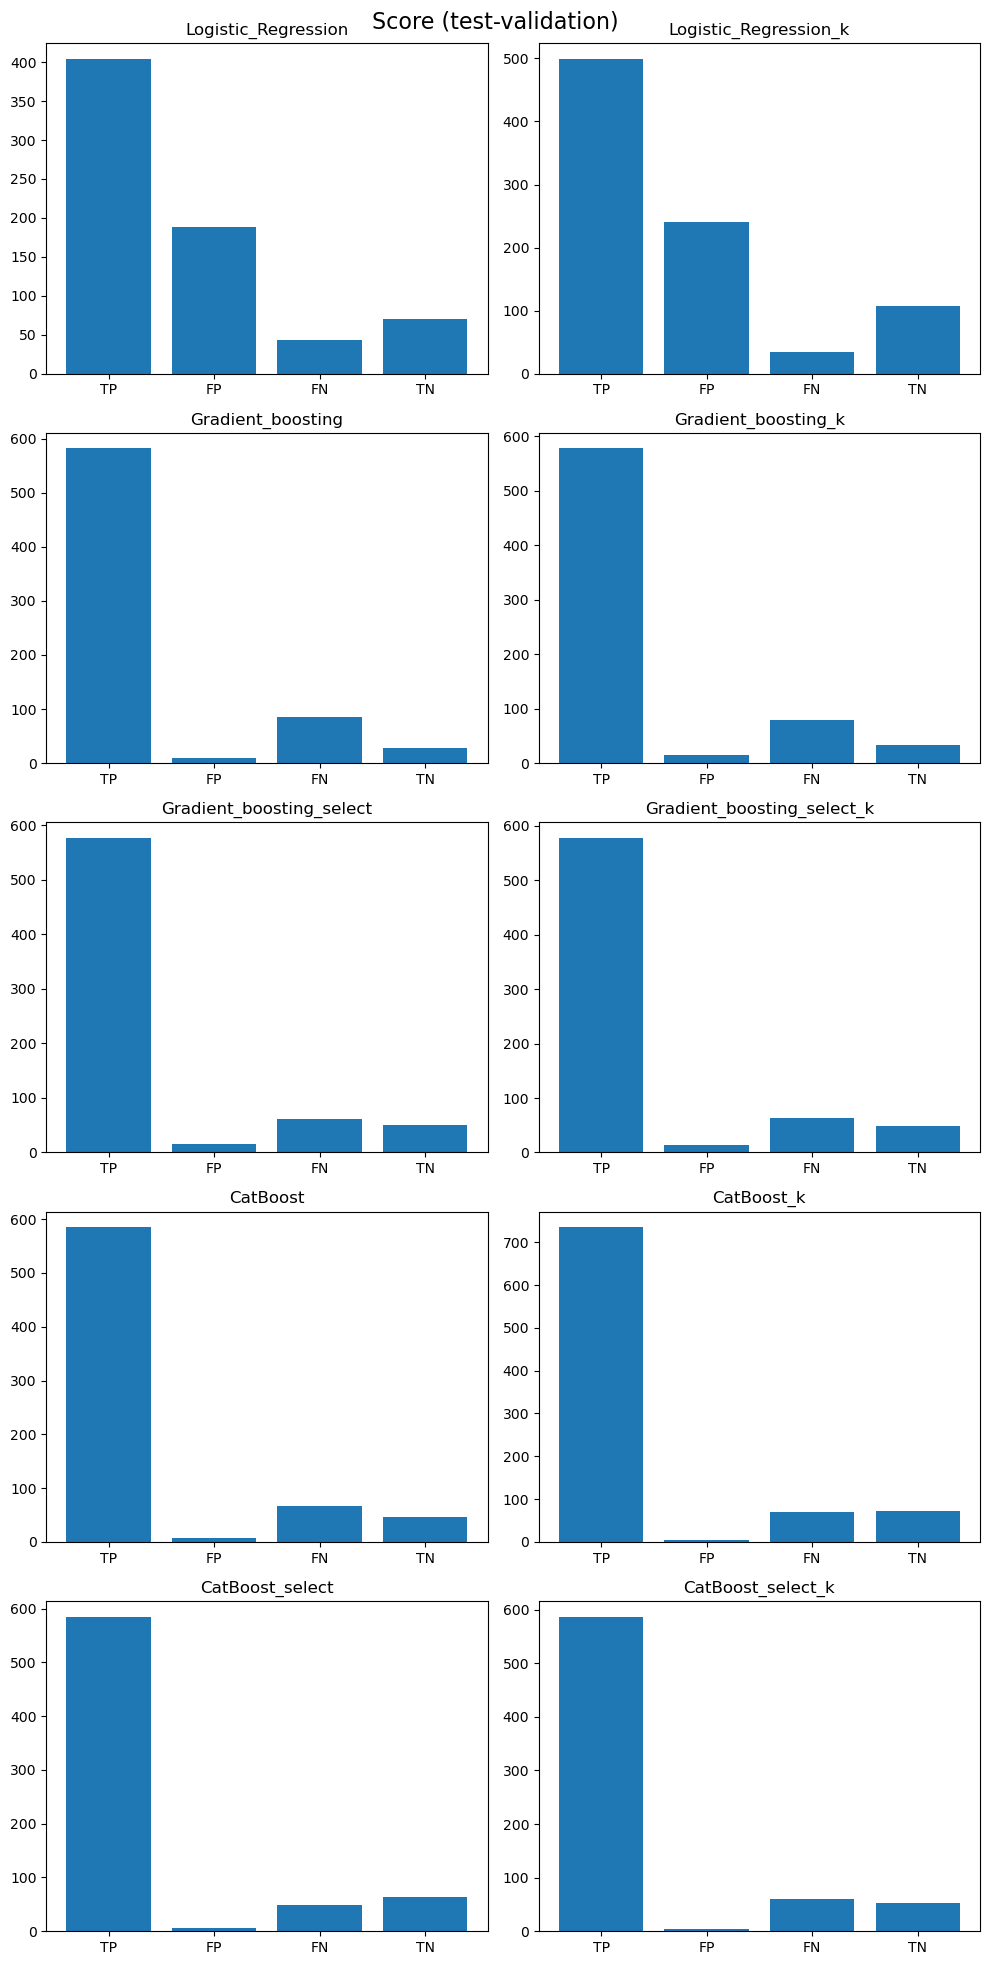

In [138]:
print("MODEL SCORES (confusion matrix):")

# Make the following plot taller
plt.rcParams['figure.figsize'] = [10, 3]

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
axs = axs.ravel()

iter = 0
for key, value in results.items():
    # If the model is the "selected_model"
    if key == "selected_model":
        continue
    axs[iter].bar(["TP", "FP", "FN", "TN"], [abs(value[2][2][0][0]), abs(value[2][2][0][1]), abs(value[2][2][1][0]), abs(value[2][2][1][1])])
    axs[iter].set_title(key)
    print(f"    {iter}. {key}: \n{abs(value[2][2])}")
    iter += 1
    
fig.suptitle("Score (test-validation)", fontsize=16)
fig.tight_layout()

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/confusion_matrix.png")
plt.show()

The confusion matrix is a matrix that displays the frequency with which a model correctly or incorrectly classifies each of the classes in a dataset. The matrix is comprised of four attributes: true positives, false positives, true negatives, and false negatives. True positives represent the number of positive cases that were accurately classified by the model, while false positives are the number of negative cases that were wrongly classified as positive. Similarly, true negatives are the number of negative cases that were accurately classified, and false negatives are the number of positive cases that were wrongly classified as negative. These attributes are utilized to determine different evaluation metrics like precision, recall, and F1 score, and to visualize the model's performance in terms of errors made and classes with the highest error rates.

Upon observation, all models display superior performance in the true positive attribute, which is expected given that the problem is unbalanced towards that values. However, there is a notable difference in the supperiority of the CatBoost_select model compared with the rest, as it is the one with the most true positive and most true negative values. This, taking into account the nature of the problem, which is to detect the employees that will leave the company, makes this model the best one (as the true negative values indicate the employees that will leave the company that are correctly classified). Also it is important to notice this model superiority in classifying false negatives, as it is crucial for the company to not make mistakes into what employees will leave the company or not.

On the other hand, the worst models are the ones of logistic regression, as it can be clearly observe in the graphs the huge amounts of false positives and negatives that they have.

Also, it is noticeable that the catboost with selection of attributes and no selection of parameters  ("CatsBoost_k") has great results in terms of true positive and true negative values, and has also been the second best model in terms of F1 score and balanced accuracy. This is a great result, as it has much lower computational costs than the best model.


#### Time

MODEL TIMES:
    0. Logistic_Regression: 2.2189462184906006
    1. Logistic_Regression_k: 3.63307785987854
    2. Gradient_boosting: 2.7161383628845215
    3. Gradient_boosting_k: 3.2694404125213623
    4. Gradient_boosting_select: 70.40972995758057
    5. Gradient_boosting_select_k: 66.69242024421692
    6. CatBoost: 23.533394813537598
    7. CatBoost_k: 22.744817972183228
    8. CatBoost_select: 353.16095066070557
    9. CatBoost_select_k: 230.3137331008911


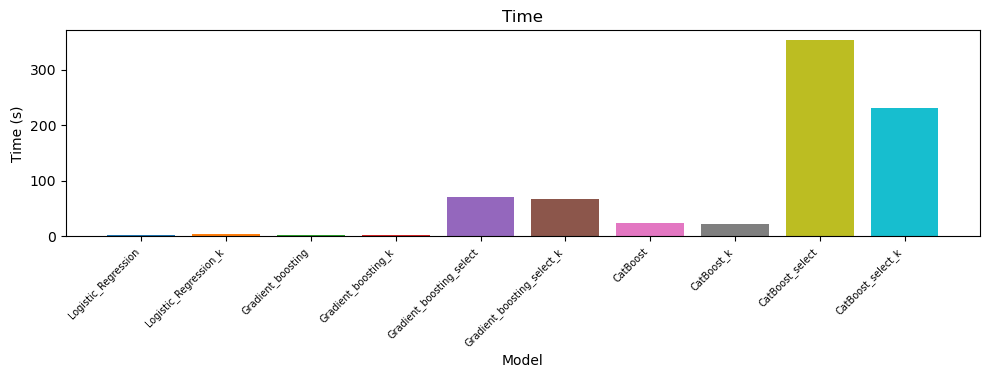

In [136]:
print("MODEL TIMES:")

# Make the following plot taller
plt.rcParams['figure.figsize'] = [10, 3]

iter = 0
for key, value in times.items():
    # If the model is the "selected_model"
    if key == "selected_model":
        continue
    plt.bar(key, abs(value))
    print(f"    {iter}. {key}: {abs(value)}")
    iter += 1
    
plt.title("Time")
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/best_methods_times.png")
plt.show()

In the graph above we can observe the time that each model takes to train and predict the test dataset. We can observe that the time is significantly higher in CatBoost than in the rest of the models. This is due to the fact that CatBoost is a newer library. We can also observe that the time is significantly lower in logistic regression than in the rest of the models. This is due to the fact that logistic regression is a simple model that is easy to train and predict, and it doesn't require any complex calculations or algorithms.

We also have gradient boosting, which is a more complex model that requires more time to train and predict than logistic regression. However, it is worth noting that gradient boosting is still much faster than CatBoost, which is the slowest model in terms of training and prediction time.

Finally, it is important to mention that for the sake of reducing the times (which are exponential in catboost), we only have 4 iterations (although we have tested with more iterations and values for the parameters), whereas, in the boosting model, we have 50 iterations. This is due to the fact that the boosting model is much faster than catboost, and therefore we can afford to have more iterations, so it is important to take this into account when comparing the times of the models.
<br>Important to note that the selection of features is done with just one value, selected from the previous analysis of the k selector of all the models. This is done to reduce the time of the models, as feature selection is a time-consuming process, especially in CatBoost. That is the reason why models like "CatBoost_k" have so low times.

MODEL VARIABLES:
    0. Logistic_Regression: 48
    1. Logistic_Regression_k: 30
    2. Gradient_boosting: 48
    3. Gradient_boosting_k: 20
    4. Gradient_boosting_select: 48
    5. Gradient_boosting_select_k: 20
    6. CatBoost: 48
    7. CatBoost_k: 30
    8. CatBoost_select: 48
    9. CatBoost_select_k: 30


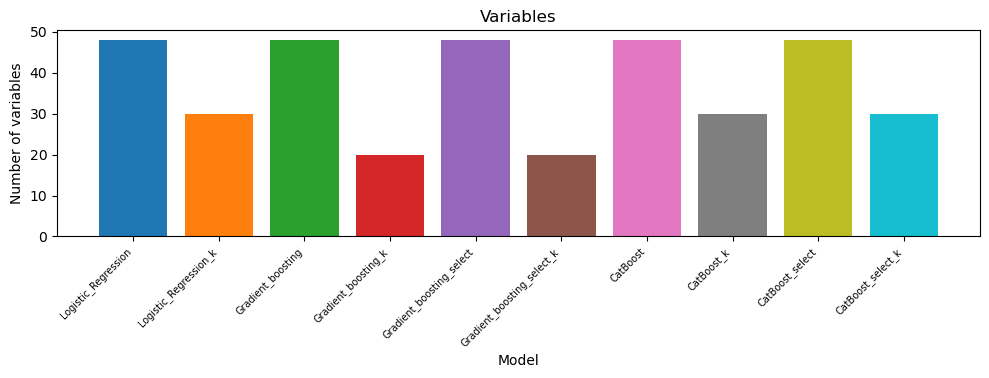

In [137]:
print("MODEL VARIABLES:")

# Make the following plot taller
plt.rcParams['figure.figsize'] = [10, 3]


iter = 0
for key, value in variables.items():
    # If the model is the "selected_model", do not plot it
    if key == "selected_model":
        continue
    plt.bar(key, abs(value))
    print(f"    {iter}. {key}: {abs(value)}")
    iter += 1

plt.title("Variables")
plt.xlabel("Model")
plt.ylabel("Number of variables")
plt.tight_layout()
 
plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/best_methods_variables.png")
plt.show()

As can be seen above, we also plotted the number of variables, and as it can be observed, there is a direct relation between the number of variables and the time and score of the models, as the more variables we have, the more complex the model is, and the more time it takes to train and predict. This is why we can observe that the models with the highest number of variables are the ones that take the most time to train and predict, but also the ones that have the highest score as they have the most information to train with.

Also, take into account that we deleted in the pipeline all the variables that do not provide any relevant information or constant ones, so every variable that gets deleted does in fact provide some information to the model, and that is why the models with the highest number of variables have a higher score than their counterparts.

---
# 6. Model evaluation

## 6.1. Best Model Selection

After carefully evaluating the results obtained from the predictions in the train-evaluation process (as shown in the graphs above) and considering various factors, we have concluded that the CatBoost model with selected parameters and without attribute selection is the best model for our dataset. This is because it achieves the highest scores on balanced accuracy, F1 score, and in the confusion matrix.

It is worth exploring alternative models with lower accuracy but faster training times, such as the parameter-free CatBoost model. This approach can be particularly beneficial in situations where computational resources are limited. However, considering the company's available resources (based on the number of employees), we believe it is possible to use a more time-consuming model that is properly trained and tuned for optimal performance.

Another reason is that retraining this model for this purpose in concrete is not a problem, as the company only needs to perform this process once a year or monthly at much. Thus, less than 20 minutes of training time should not be a problem. 
<br>However, if the company were to perform this process more frequently, it would be advisable to use a model with a shorter training time, such as the parameter-free CatBoost model. Although if a company has a high turnover rate of employees, it is possible that they may have the necessary computational resources to use the model with the best accuracy possible.

Moreover, since the company aims to identify employees who may leave, having a highly accurate model is crucial to avoid missing potential cases. Therefore, investing in the model with the best accuracy possible, even if it requires more computational resources and training time, may be the best decision. In summary, the higher accuracy of the selected CatBoost model with selected features may outweigh any potential drawbacks, being the most suitable model for the company's needs.

### 6.1.1. Compare to the a "dummy model"

A dummy model which predict the mode of the target variable (in this case, 'Attrition') would be as follows:

In [94]:
# Check the train-test division correctness by comparing the class distribution in the original dataset and the train and test sets.
print("\n--------------------\n")
print("Original dataset class distribution (numerical):\n", datos_copy['Attrition'].value_counts())
print("\n--------------------\n")
print("Train set class distribution (numerical):\n", y_train.value_counts())
print("\n--------------------\n")
print("Test set class distribution (numerical):\n", y_test.value_counts())
print("\n--------------------\n")


--------------------

Original dataset class distribution (numerical):
 No     3699
Yes     711
Name: Attrition, dtype: int64

--------------------

Train set class distribution (numerical):
 No     2959
Yes     569
Name: Attrition, dtype: int64

--------------------

Test set class distribution (numerical):
 No     740
Yes    142
Name: Attrition, dtype: int64

--------------------



As we can see, it has 740 NO, which is the largest number of the target variable, and 142 YES, which is the smallest number of the target variable. Therefore, the dummy model would predict NO for all the samples, which would lead to a balanced.

We could compare this value easily compararing it with the confusion matrix of the best model.

Dummy model confusion matrix would be as follows:[[740, 0],[142, 0]]

|                | Actual Positive   | Actual Negative    |
|----------------|-------------|---------------| 
| **Predicted Positive**   | 740         | 142           |
| **Predicted Negative**  | 0           | 0             |

Note: No is the mode of the target variable, which is the most frequent value, and it is the positive value for this table explanation.



In [95]:
# Access the third value of the model with key "CatBoost_select" in the dictionary "results" in the train
score = results["CatBoost_select"][2]

print("Best model confusion matrix:")
print(score[2])

Best model confusion matrix:
[[585   7]
 [ 49  64]]


As we can observe, the best model confusion matrix is:

|                | Actual Positive   | Actual Negative    |
|----------------|-------------|---------------| 
| **Predicted Positive**   | 585         | 7             |
| **Predicted Negative**  | 49          | 64            |


Whereas the dummy model would have been:

|                | Actual Positive   | Actual Negative    |
|----------------|-------------|---------------| 
| **Predicted Positive**   | 634         | 71             |
| **Predicted Negative**  | 0          | 0            |

Porcentually, it is a difference of 7.728% of error for positive values and  9.86% of error for negative values in the **best model**, whereas the dummy model has 0% of error for positive values and 100% of error for **negative values**.

But globally, the errors for the dummy model would be: 56*100/705 = 7.94% for the best model and 71 *100/634 = 10.07%.

This is a great difference taking into account that we are talking about thousands of employees and their jobs, and therefore it is more important to predict the employees that are leaving the company (the dummy model does not provide any valuable information, as it predicts as a constant 0 the number of employees leaving). Also, it is important to take into account that the target variable is very unbalanced.

### 6.1.2. Best Model Prediction - Test

In [96]:
# We select the best model: CatBoost_select 
model = models["CatBoost_select"]

# We calculate the subsets used for training and testing in the different folds of the cross-validation
# validation_splits(model, X_train)  # We al ready did the 5th fold split at the begginning

# We obtain the different scores of the model
score = train_validation_test(
    model,
    model.best_estimator_,
    X_train,
    y_train,
    folds_array_select_cat, # Array for the folds of the CatBoost_select model
    True,
    X_test,
    y_test,
)


--------------------

MODEL: <catboost.core.CatBoostClassifier object at 0x7fbc99caa380>
MODEL PARAMETERS: {'model__learning_rate': 0.075, 'model__l2_leaf_reg': 2, 'model__iterations': 2000, 'model__depth': 8}


--------------------

TRAIN SET
Balanced accuracy in train set: 0.9557591714770879
F1 score in train set: 0.9489051094890512
Confusion matrix in train set:
 [[2952    7]
 [  49  520]]

--------------------

TEST SET
Balanced accuracy in test set: 0.7860296916634946
F1 score in test set: 0.7192982456140351
Confusion matrix in test set:
 [[736   4]
 [ 60  82]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 1.0
F1 score in train validation set: 1.0
Confusion matrix in train validation set:
 [[2367    0]
 [   0  456]]

--------------------

TEST VALIDATION SET
Balanced accuracy in test validation set: 0.7772736785458024
F1 score in test validation set: 0.6956521739130435
Confusion matrix in test validation set:
 [[585   7]
 [ 49  64]]

-----

As we hypothesized before, the test scores are better than the validation scores (all f1 score, balanced accuracy and confusion matrix (normalised)), which is a good sign and expected as the validation was an understimation. 

Overall, the test score is very good, with a result of:<br>
- Balanced accuracy in test set: 0.8101446516939474<br>
- F1 score in test set: 0.7438016528925621<br>
- Confusion matrix in test set:
    <br>[[730  10]
    <br>[ 52  90]]

## 6.2. Selected Model Training

Once selected the best model, we will train with all the data we have available, and then we will use it to predict the values of the competition dataset.

First, we divide the whole dataset into the training set (inputs, X, and outputs, y). Then, we train the model with the whole dataset, and to be predicted, the model should perform better than the one we selected first, as it has more training data.

### 6.2.1. Selected Model Prediction and Comparison

In [97]:
# whole train set -> train_set
# whole test set -> test_set

# We use the whole dataset to train the model
datos_copy = datos.copy()

X_train = datos_copy.drop("Attrition", axis=1)
y_train = datos_copy["Attrition"]

In [98]:
""" Best model: CatBoost_select re-trained with the whole training set and tested with the test set """

np.random.seed(2)

budget = 4

param_grid_cat = {
    'model__iterations': [1500, 2000],# 1000, 1500  # ? Number of trees
    'model__learning_rate': [0.075, 0.1], # [0.075, 0.1, 0.15], as we can observe in the plot, the value 0.1 is the best
    'model__depth': [8],
    'model__l2_leaf_reg': [2] # [1, 3, 5, 7, 9] -> As we can observe in the plot, the value 2 is the best 
}

folds_array = []

best_model = RandomizedSearchCV(
    preprocessing_pipeline_cat,
    param_grid_cat,
    cv=stratified_kfold_last_split(folds_array),
    scoring="balanced_accuracy",
    n_iter=budget,
    random_state=2,
    n_jobs=-1,
)

start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()

time_lr = end_time - start_time

score = train_validation_test(best_model, best_model.best_estimator_, X_train, y_train, folds_array) #, X_test, y_test, test=True)
print(f"TOTAL FIT TIME: {time_lr}")

models["selected_model"] = best_model
results["selected_model"] = score
times["selected_model"] = time_lr


--------------------

MODEL: <catboost.core.CatBoostClassifier object at 0x7fbc99cd6a40>
MODEL PARAMETERS: {'model__learning_rate': 0.075, 'model__l2_leaf_reg': 2, 'model__iterations': 2000, 'model__depth': 8}


--------------------

TRAIN SET
Balanced accuracy in train set: 1.0
F1 score in train set: 1.0
Confusion matrix in train set:
 [[3699    0]
 [   0  711]]

--------------------

TRAIN VALIDATION SET
Balanced accuracy in train validation set: 1.0
F1 score in train validation set: 1.0
Confusion matrix in train validation set:
 [[2959    0]
 [   0  569]]

--------------------

TEST VALIDATION SET
Balanced accuracy in test validation set: 0.8269318614389036
F1 score in test validation set: 0.7768595041322315
Confusion matrix in test validation set:
 [[734   6]
 [ 48  94]]

--------------------

TOTAL FIT TIME: 356.94631695747375


As it can be observed the **result of the prediction in the test-validation set is even better** than the prediction of the **previous best model** with partial dataset training. This is a good sign, as it is an underestimation  of the model's performance, and if the underestimation  in the validation fold is better than before the whole test, means that potentially this new model with the whole dataset as training data will perform even better than the previous one.

Overall these are all very good results, with a result of (in test validation):<br>
- Balanced accuracy in test validation set: 0.8269318614389036<br>
- F1 score in test validation set: 0.7768595041322315<br>
- Confusion matrix in test validation set:<br> 
    [[734  6]<br>
    [ 48  94]]

To show the improvement of the model, we will now plot the results of this new selected model compared to the previous ones, in terms of balanced accuracy and f1 score.

MODEL SCORES (Balanced Accuracy Test Validation):
    0. Logistic_Regression: 0.6509507294905525
    1. Logistic_Regression_k: 0.7174438523030072
    2. Gradient_boosting: 0.6154478593637885
    3. Gradient_boosting_k: 0.6341933747907199
    4. Gradient_boosting_select: 0.7129947978952403
    5. Gradient_boosting_select_k: 0.7049898349677111
    6. CatBoost: 0.6976276608466874
    7. CatBoost_k: 0.750142748382185
    8. CatBoost_select: 0.7772736785458024
    9. CatBoost_select_k: 0.7258655226022482
    10. selected_model: 0.8269318614389036


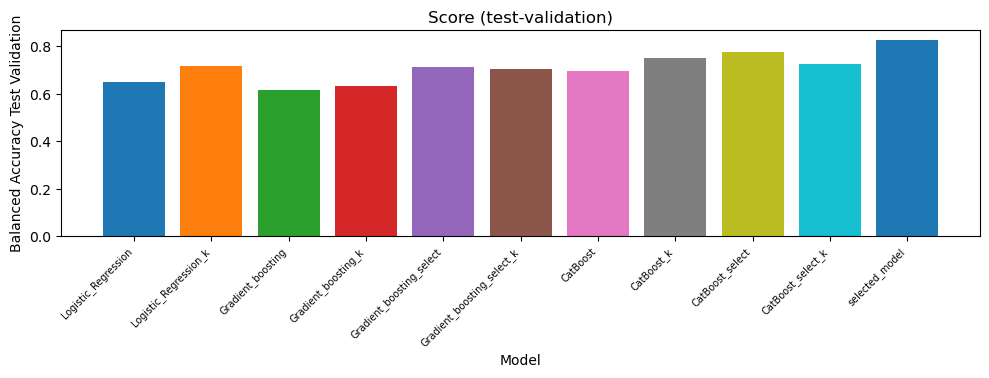

MODEL SCORES (F1 Test Validation):
    0. Logistic_Regression: 0.3773584905660377
    1. Logistic_Regression_k: 0.439918533604888
    2. Gradient_boosting: 0.3708609271523179
    3. Gradient_boosting_k: 0.4125
    4. Gradient_boosting_select: 0.5698324022346368
    5. Gradient_boosting_select_k: 0.5568181818181819
    6. CatBoost: 0.5542168674698795
    7. CatBoost_k: 0.6575342465753424
    8. CatBoost_select: 0.6956521739130435
    9. CatBoost_select_k: 0.6117647058823529
    10. selected_model: 0.7768595041322315


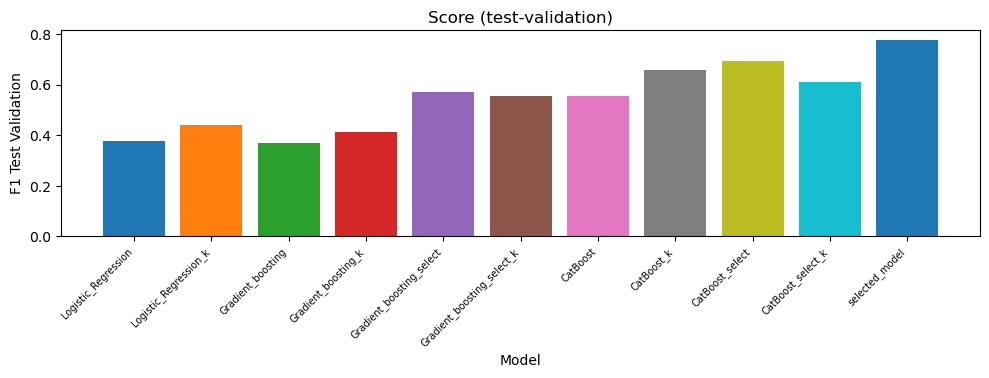

In [143]:
plt.rcParams['figure.figsize'] = [10, 3]

print("MODEL SCORES (Balanced Accuracy Test Validation):")
iter = 0
for key, value in results.items():
    plt.bar(key, abs(value[2][0]))
    print(f"    {iter}. {key}: {abs(value[2][0])}")
    iter += 1

plt.title("Score (test-validation)")
plt.xlabel("Model")
plt.ylabel("Balanced Accuracy Test Validation")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/balanced_accuracy.png")
plt.show()

print("MODEL SCORES (F1 Test Validation):")
iter = 0
for key, value in results.items():
    plt.bar(key, abs(value[2][1]))
    print(f"    {iter}. {key}: {abs(value[2][1])}")
    iter += 1
    
plt.title("Score (test-validation)")
plt.xlabel("Model")
plt.ylabel("F1 Test Validation")
plt.tight_layout()

plt.xticks(rotation=45, ha='right', size=7)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/f1_score.png")
plt.show()

## 6.3. Selected Model Export

In [99]:
import pickle

print(models["selected_model"].best_params_)

selected_model = models["selected_model"]

print(f"\nSelected model: {selected_model}, {type(selected_model)}, {selected_model.best_params_}")

# Export model as pickle file in ../data/model folder
with open("../data/model/modelo_final.pkl", "wb") as file:
    pickle.dump(selected_model, file)

# ! Compare the model exported with the one loaded - check if it is the same
# Load model from pickle file
with open("../data/model/modelo_final.pkl", "rb") as file:
    loaded_model = pickle.load(file)

print(f"\nSaved model: {loaded_model}, {type(loaded_model)}, {loaded_model.best_params_}")
    
if selected_model.best_params_ == loaded_model.best_params_:
    print("\n\nThe models has been saved and loaded correctly")
else:
    print("\n\nERROR: The models are different")

{'model__learning_rate': 0.075, 'model__l2_leaf_reg': 2, 'model__iterations': 2000, 'model__depth': 8}

Selected model: RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('drop_over18',
                                                                               'drop',
                                                                               ['Over18']),
                                                                              ('drop_employeeid',
                                                                               'drop',
                                                                               ['EmployeeID']),
                                                                              ('drop_standardhours',
                                                                               'drop',
                                                                            

---
# 9. Final Conclusions

Throughout this project, we have gained a deeper understanding of the model selection process using Catboost, gradient boost, and logistic regression models with sklearn. Our data preprocessing was more extensive than in previous project, involving the encoding of categorical variables and dropping insignificant attributes. The exploratory data analysis (EDA) phase played a crucial role in helping us manage and understand our data better, serving as a foundation for our decisions throughout the project.

Using multiple pipelines (and a column transformer), we were able to create and train all of our models (including CatBoost, Gradient Boost, and Logistic Regression), with special attention paid to hyperparameters. This approach allowed us to gain a better understanding of how various hyperparameters (and the selection of attributes) impact the performance of each model. By evaluating the results of each model, we gained valuable insights into their respective strengths and weaknesses in terms of scoring and training time.

In conclusion, during this second project, we gained a deeper understanding of classification problems and the use of the proposed models, as well as a better understanding of pipelines and column transformers for data preprocessing and model training. We also gained a deeper understanding of the use of hyperparameters and how they affect the model's performance.

---
# X. Output the Jupyter Notebook as an HTML file

In [146]:
import os

# Export the notebook to HTML
os.system("jupyter nbconvert --to html model.ipynb --output ../data/html/model.html")
print("Notebook exported to HTML")


[NbConvertApp] Converting notebook model.ipynb to html


Notebook exported to HTML


[NbConvertApp] Writing 3853976 bytes to ../data/html/model.html
